# Presenting monthly updates results



Ensure the correct version of the mapper is installed. Version 1.8.0

Run "pip install views_mapper2 --upgrade" if out of date

dummy_common_variable.py is currently in use as a stand in for .py file that will help identify the run information for current and past month.

Print function are starting to integrate checkpoint for when this notebook is converted into .py file.

In [1]:
!pip freeze | grep views-mapper2

views-mapper2==1.9.0


# Defining universals

In [2]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

import warnings
warnings.filterwarnings('ignore')

#Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views

#import views_dataviz
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *

#Data fetching of predictions, note the rewrite required to make the .py files work from a different folder
import sys
import os
#fix for the Ensembling folder location in comparison to the working directory
def get_2up_dir(directory):
    import os
    return os.path.dirname(os.path.dirname((directory)))  
viewsforecasting = get_2up_dir(os.getcwd())
sys.path.append(viewsforecasting+'/Tools')
sys.path.append(viewsforecasting+'/Intermediates')
sys.path.append(viewsforecasting+'/SystemUpdates')

from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated
from FetchData import FetchData, RetrieveFromList
from ViewsEstimators import *

#MapperTools
import os
import geopandas as gpd
import sqlalchemy as sa
from ingester3.config import source_db_path
from views_mapper2.mapper2 import *
from views_mapper2.dictionary_writer import *
from views_mapper2.BBoxWriter import *
from views_mapper2.label_writer import *

#defining the common parameters, currently a dummy file
from dummy_common_variables import *

In [3]:
home = os.path.expanduser("~")
user = os.getlogin()
Mydropbox = home + '/Dropbox (ViEWS)/ViEWS/'
#Monthly_updates = Mydropbox + 'DataReleases/MonthlyUpdates/'
Monthly_updates = home + '/Desktop/'
label_version = dev_id_cm + '_' + 'genetic'
master_folder = Monthly_updates + label_version+'_'+prod_id_cm+'_delete_when_done'

#new folderpath
make_folders_complete_set(master_folder)

# Havard specific code for write directly to overleaf
if os.getlogin() == 'havardhegre1':
    WriteToOverleaf = True
    overleafpath = f'/Users/havardhegre1/Dropbox (ViEWS)/Apps/Overleaf/VIEWS documentation Fatalities002/Figures/'

Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done already exists
Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done/Features already exists
Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done/Features/Maps already exists
Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done/Features/Maps/cm already exists
Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done/Features/Maps/pgm already exists
Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done/Features/ChangeMaps already exists
Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done/Features/ChangeMaps/cm already exists
Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done/Features/ChangeMaps/pgm already exists
Directory /Users/malika/Desktop/Fatalities001_genetic_2022_04_t01_delete_when_done/Dichotom

In [4]:
#Read in future predictions at cm level as given by the parameters above
#note that the output step combined is already log transformed

predstore_future = level_cm +  '_' + 'genetic_ensemble' + '_f' + str(EndOfHistory)
predstore_future_dich = level_cm +  '_' + 'genetic_ensemble' + '_dich_f' + str(EndOfHistory)

predictions_df = pd.DataFrame.forecasts.read_store(predstore_future, run=dev_id_cm)
predictions_dich_df = pd.DataFrame.forecasts.read_store(predstore_future_dich, run=dev_id_cm)

#Redefine month_id into steps as a index, change the name of some variables for consistency/workability with code
#note step combined is already a log transformed variable that uses state-based violence
predictions_df = predictions_df.reset_index()
predictions_df['step'] = predictions_df['month_id'] - EndOfHistory
predictions_df = predictions_df.set_index(['step', 'country_id'], drop = True)
predictions_df['ln1_step_combined_sb'] = predictions_df['step_combined']
predictions_df['ln2_step_combined_sb'] = np.log1p(predictions_df['ln1_step_combined_sb'])

#predictions_dich_df gives state based violence
predictions_dich_df = predictions_dich_df.reset_index()
predictions_dich_df['step'] = predictions_dich_df['month_id'] - EndOfHistory
predictions_dich_df = predictions_dich_df.set_index(['step', 'country_id'], drop = True)
predictions_dich_df['step_combined_sb'] = predictions_dich_df['step_combined']

print(f'{user}, prediction data successfully fetched')

pr_45_cm_genetic_ensemble_f508.parquet
pr_45_cm_genetic_ensemble_dich_f508.parquet
malika, prediction data successfully fetched


In [5]:
##identify the top 1 countries with overall cumulative prediction
#this step is needed as I will automate the country specific mapping to only one
#(please let me know if we want more than just the top 1)

top1= give_me_topX_country_id_cumulative(df=predictions_df, time_index = 'step', number_wanted = 1,
                                           variable = 'ln1_step_combined_sb', start = 1, end = 36)

countries_to_map = top1

print(f'{user}, the following country ids will be mapped as highest predicted cumulative fatalities {top1}')

malika, the following country ids will be mapped as highest predicted cumulative fatalities [124]


# Features
- GED, libdem, gdp per capita
- GED in rainbow, libdem and gdp per capita in other colormaps to make a distinction for non-fatality based

## cm features maps

In [6]:
features_qs = (Queryset("Monthly_update_features_cm", "country_month")


    # target variable
    .with_column(Column("ged_sb_ln1", from_table = "ged2_cm", from_column = "ged_sb_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.ops.ln()
        )
      .with_column(Column("ged_ns_ln1", from_table = "ged2_cm", from_column = "ged_ns_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.ops.ln()
        )
      .with_column(Column("ged_os_ln1", from_table = "ged2_cm", from_column = "ged_os_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.ops.ln()
        )
    .with_column(Column("vdem_v2x_libdem", from_table = "vdem_v12_cy", from_column = "vdem_v12_v2x_libdem")
        .transform.missing.replace_na()
        )
    .with_column(Column("wdi_sp_dyn_imrt_in", from_table = "wdi_cy", from_column = "wdi_sp_dyn_imrt_in")
                         .transform.missing.fill()
                         .transform.temporal.tlag(12)
                         .transform.missing.fill()
        )
    .with_column(Column("wdi_ny_gdp_mktp_kd", from_table = "wdi_cy", from_column = "wdi_ny_gdp_mktp_kd")
                 .transform.missing.fill()
                 .transform.temporal.tlag(12)
                 .transform.missing.fill()
                )
    .with_column(Column("wdi_sp_pop_totl", from_table = "wdi_cy", from_column = "wdi_sp_pop_totl")
                 .transform.missing.fill()
                 .transform.temporal.tlag(12)
                 .transform.missing.fill()
                )
    .with_theme("monthly_update")
                         
            .describe("""Features for the monthly report""")
              )

features_cm=features_qs.publish().fetch()

#prepare data
features_cm['gdp_pc']=features_cm['wdi_ny_gdp_mktp_kd']/features_cm['wdi_sp_pop_totl']
features_cm['gdp_pc_ln1']=np.log(features_cm['gdp_pc'])
features_cm['ged_sb_ln2']=np.log1p(features_cm['ged_sb_ln1'])
features_cm['ged_ns_ln2']=np.log1p(features_cm['ged_ns_ln1'])
features_cm['ged_os_ln2']=np.log1p(features_cm['ged_os_ln1'])

print(f'{user} cm_current_data fetched successfully')

 .    malika cm_current_data fetched successfully


In [7]:
#obtaining cm level geometries
engine = sa.create_engine(source_db_path)
gdf_ci_master = gpd.GeoDataFrame.from_postgis(
    "SELECT id as country_id, name, in_africa, in_me, geom FROM prod.country",
    engine,
    geom_col='geom'
)
gdf_ci_master = gdf_ci_master.to_crs(4326)

In [8]:
#cm level features mapping, ged

#prep data
data= features_cm.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#savefolder
features_cm_folder = master_folder+'/Features/Maps/cm/'

#looping informationa
geo_coverage_loop = ['globe', 'ame'] + countries_to_map
variable_loop = {'ged_sb_ln2', 'ged_ns_ln2', 'ged_os_ln2'}
steps_loop = {EndOfHistory, EndOfHistory-1}

dictionary_run = dictionary_stand_2p_10k

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
            data_run = gdf.loc[step]
            var_run = variable
            var_name_run = find_the_violence_type(variable)
            var_run_savefile = give_me_violence_string_label_only(variable)
            bbox_run = bbox_from_cid_region(region_name)                       
                        
            #making the choice of textbox size
            if str(region_name) in('globe'):
                textbox_font_size = 10
            elif str(region_name) in ('ame', 'africa'):
                textbox_font_size = 20
            else:textbox_font_size = 15
                        
            title_run = f'Actual fatalities in {str(vid2date(step))}, {var_name_run}'
            textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
            savefile = f'{features_cm_folder}GED_cm{var_run_savefile}_{region_name}_rainbow_month{step}.png'
            
            if region_name in ('globe', 'ame', 'africa'):
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_layer(
                    gdf=data_run,
                    map_dictionary=dictionary_run,
                    cmap='binary',
                    edgecolor="black",
                    linewidth=0.5,
                    transparency = 1.0,
                    column=var_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = 'rainbow',
                    transparency = 1,
                    masking_location = region_name,
                    column=var_run,
                    edgecolor="black",
                    linewidth=1
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
            else:
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = 'rainbow',
                    transparency = 0.8,
                    background = 'OpenStreetMap',
                    masking_location = str(cid2name(region_name)),
                    column=var_run,
                    edgecolor="black",
                    linewidth=1, 
                    views_experimental_labels = 15
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
print(f'{user}, cm maps for ged completed')

malika, cm maps for ged completed


In [9]:
#cm features map, all others
#prep data
data= features_cm.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#savefolder
features_cm_folder = master_folder+'/Features/Maps/cm/'

#looping information
geo_coverage_loop = ['globe', 'ame'] + countries_to_map
variable_loop = {'vdem_v2x_libdem','gdp_pc_ln1', "wdi_sp_dyn_imrt_in"}
steps_loop = {EndOfHistory, EndOfHistory-1}

#custom_dictionaries
libdem_values=np.array([0,0.2,0.4,0.6,0.8,1.0])
libdem_ticklabels=[str(tv) for tv in libdem_values]
libdem_dictionary = dict(zip(libdem_ticklabels, libdem_values))

gdp_raw_values = np.array([150,500,1500,5000,15000,50000])
gdp_values = np.array(np.log([150,500,1500,5000,15000,50000]))
gdp_ticklabels = [str(tv) for tv in gdp_raw_values]
gdp_dictionary = dict(zip(gdp_ticklabels, gdp_values))

imr_values = np.array([0,20,40,60,80,100])
imr_ticklabels = [str(tv) for tv in imr_values]
imr_dictionary = dict(zip(imr_ticklabels, imr_values))

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
            data_run = gdf.loc[step]
            var_run = variable
            
            if variable == 'vdem_v2x_libdem':
                var_name_run = 'liberal democracy index'
            if variable == 'gdp_pc_ln1':
                var_name_run = 'GDP per capita, logged'
            if variable == 'wdi_sp_dyn_imrt_in':
                var_name_run = 'infant mortality rate per 1,000 live births'

            var_run_savefile = variable
            bbox_run = bbox_from_cid(region_name)                       
                        
            #making the choice of textbox size
            if str(region_name) in('globe'):
                textbox_font_size = 10
            elif str(region_name) in ('ame', 'africa'):
                textbox_font_size = 20
            else:textbox_font_size = 15
                
            #making the dictionary_run choice
            if variable == 'vdem_v2x_libdem': 
                dictionary_run = libdem_dictionary
                cmap_run = 'viridis_r'
            if variable == 'gdp_pc_ln1': 
                dictionary_run = gdp_dictionary
                cmap_run = 'viridis_r'
            if variable == 'wdi_sp_dyn_imrt_in': 
                dictionary_run = imr_dictionary
                cmap_run = 'viridis'
                        
            title_run = f'{var_name_run} in {str(vid2date(step))}'
            textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
            savefile = f'{features_cm_folder}{var_run_savefile}_cm_{region_name}_{cmap_run}_month{step}.png'
            
            if region_name in ('globe', 'ame', 'africa'):
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_layer(
                    gdf=data_run,
                    map_dictionary=dictionary_run,
                    cmap='binary',
                    edgecolor="black",
                    linewidth=0.5,
                    transparency = 1.0,
                    column=var_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = cmap_run,
                    transparency = 1,
                    masking_location = region_name,
                    column=var_run,
                    edgecolor="black",
                    linewidth=1
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
            else:
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = cmap_run,
                    transparency = 0.8,
                    background = 'OpenStreetMap',
                    masking_location = str(cid2name(region_name)),
                    column=var_run,
                    edgecolor="black",
                    linewidth=1, 
                    views_experimental_labels = 15
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
print(f'{user}, cm maps for all other variables completed')

malika, cm maps for all other variables completed


## cm change maps
specification: we are shifting by delta 1 month, so change in value from 1 months ago

In [10]:
conf_types=['sb','ns','os']
delta=1 # 1 month
for conf_type in conf_types:
    column='ged_'+conf_type + '_ln1'
    actual=np.exp(features_cm[column])-1
    shifted=np.exp(features_cm[column].groupby(level=1).shift(periods=delta))-1    
    
    features_cm['ln1_delta_'+str(delta)+'_'+column]=np.sign(actual-shifted)*np.log(np.abs(actual-shifted)+1)

In [12]:
#note change maps will denote the following, increase from the past is red (things got worse, more fatalities)
#decrease is blue (things got better, less fatalities)
#no change is white

data= features_cm.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#savefolder
features_change_cm_folder = master_folder+'/Features/ChangeMaps/cm/'

#looping information
geo_coverage_loop = ['globe', 'ame'] + countries_to_map
variable_loop = {'ln1_delta_1_ged_sb_ln1', 'ln1_delta_1_ged_ns_ln1', 'ln1_delta_1_ged_os_ln1'}
steps_loop = {EndOfHistory}

#custom dictionary for this run
change_raw_values = np.array([-300,-30,-3,3,30,300])
change_values = np.sign(change_raw_values)*np.log(np.abs(change_raw_values)+1)
change_ticklabels = [str(tv) for tv in change_raw_values]
change_dictionary = dict(zip(change_ticklabels, change_values))

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
            data_run = gdf.loc[step]
            var_run = variable
            var_name_run = find_the_violence_type(variable)
            var_run_savefile = give_me_violence_string_label_only(variable)
            bbox_run = bbox_from_cid(region_name)
            
            cmap_run = 'bwr'
                        
            #making the choice of textbox size
            if str(region_name) in('globe'):
                textbox_font_size = 10
            elif str(region_name) in ('ame', 'africa'):
                textbox_font_size = 20
            else:textbox_font_size = 15
            
            dictionary_run = change_dictionary
                        
            title_run = f'Change in fatalities from {delta} month ago on {str(vid2date(step))}, {var_name_run}'
            textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
            savefile = f'{features_change_cm_folder}ChangeMaps_GED_cm{var_run_savefile}_{region_name}_bwr_month{step}.png'
            
            if region_name in ('globe', 'ame', 'africa'):
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_layer(
                    gdf=data_run,
                    map_dictionary=dictionary_run,
                    cmap='binary',
                    edgecolor="black",
                    linewidth=0.5,
                    transparency = 1.0,
                    column=var_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = cmap_run,
                    transparency = 1,
                    masking_location = region_name,
                    column=var_run,
                    edgecolor="black",
                    linewidth=1
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
            else:
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = cmap_run,
                    transparency = 0.8,
                    background = 'OpenStreetMap',
                    masking_location = str(cid2name(region_name)),
                    column=var_run,
                    edgecolor="black",
                    linewidth=1, 
                    views_experimental_labels = 15
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
print(f'{user}, cm change maps for ged completed')

malika, cm change maps for ged completed


## pgm level, features maps

In [13]:
#obtain data
features_pgm_qs = (Queryset("Monthly_update_features_pgm", "priogrid_month")


    # target variable
    .with_column(Column("ged_sb_ln1", from_table = "ged2_pgm", from_column = "ged_sb_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.ops.ln()
        )
      .with_column(Column("ged_ns_ln1", from_table = "ged2_pgm", from_column = "ged_ns_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.ops.ln()
        )
      .with_column(Column("ged_os_ln1", from_table = "ged2_pgm", from_column = "ged_os_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.ops.ln()
        )
    
    .with_theme("monthly_update")
                         
            .describe("""Features for the monthly report""")
              )

features_pgm=features_pgm_qs.publish().fetch()

#prepare data

features_pgm['ged_sb_ln2']=np.log1p(features_pgm['ged_sb_ln1'])
features_pgm['ged_ns_ln2']=np.log1p(features_pgm['ged_ns_ln1'])
features_pgm['ged_os_ln2']=np.log1p(features_pgm['ged_os_ln1'])

print(f'{user} pgm_current_data fetched successfully')

 .    malika pgm_current_data fetched successfully


In [14]:
#fetching geometries
engine = sa.create_engine(source_db_path)
gdf_pid = gpd.GeoDataFrame.from_postgis(
    "SELECT id as priogrid_gid, in_africa, in_me, geom FROM prod.priogrid", 
    engine, 
    geom_col='geom'
)
gdf_pid = gdf_pid.to_crs(4326)

#now grab the country names
pg_country_queryset = (Queryset("m_associate_country_2_priogrid", "priogrid_month")
              #CONFLICT TYPES NOT LOGGED and NOT time lagged 
            #.with_column(Column("month_id", from_table = "priogrid_month", from_column = "month_id"))
            .with_column(Column('name', from_table = 'country', from_column = 'name'))
                             
            .with_theme("Mapping")
                         
            .describe("""Mapping, allows for association of priogrid with country 
                
            """)
            
           )
pg_country = pg_country_queryset.publish().fetch().reset_index()
#pg_country_cleaned = pg_country.reset_index().drop(['month_id'], axis = 1).drop_duplicates(subset=['priogrid_gid'])

gdf_pid_master = pd.merge(left = gdf_pid, right = pg_country, left_on = 'priogrid_gid', 
                          right_on = 'priogrid_gid', how = 'right').set_index(['month_id', 'priogrid_gid'])


#grab country geometries for borders creation
gdf_ci_master = gpd.GeoDataFrame.from_postgis(
    "SELECT id as country_id, name, in_africa, in_me, geom FROM prod.country",
    engine,
    geom_col='geom'
)
gdf_ci_master = gdf_ci_master.to_crs(4326)

 .    

malika, pgm maps for ged completed


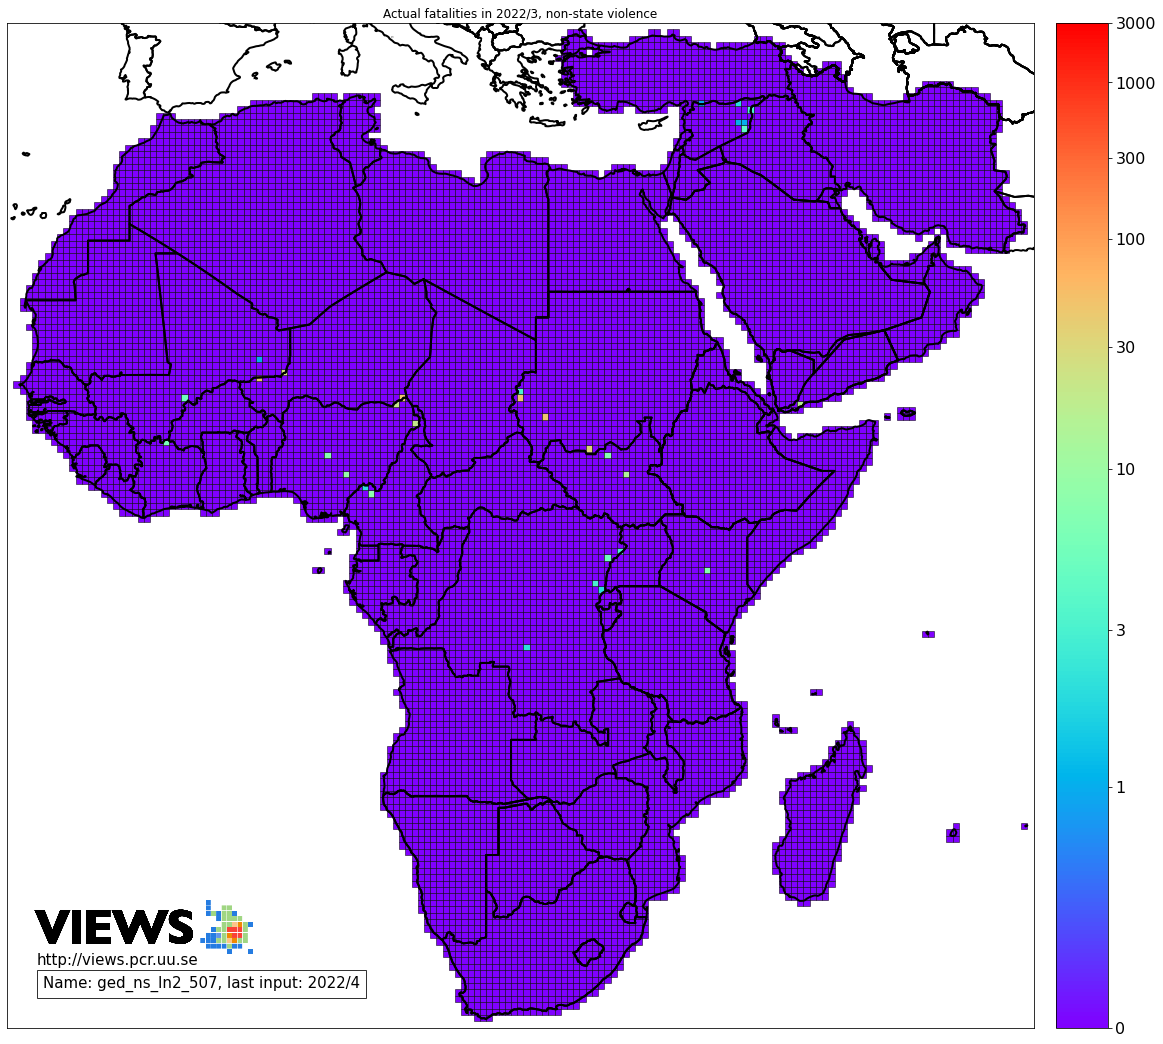

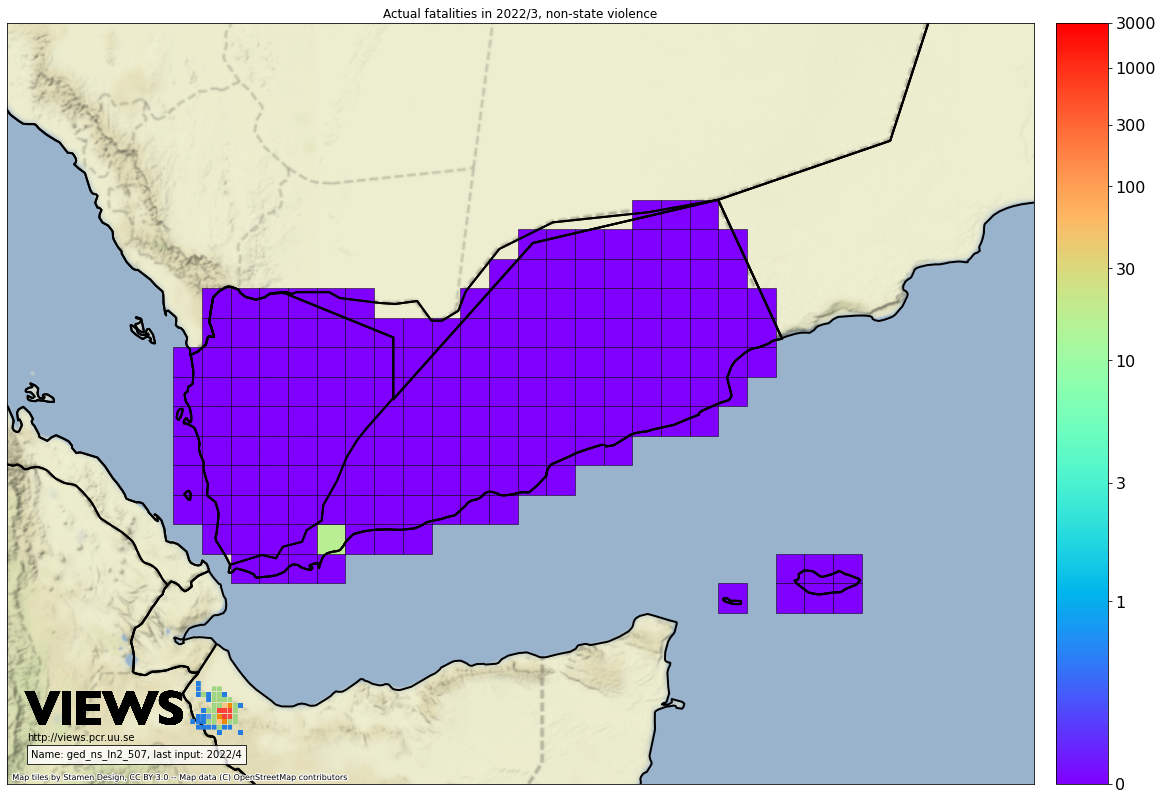

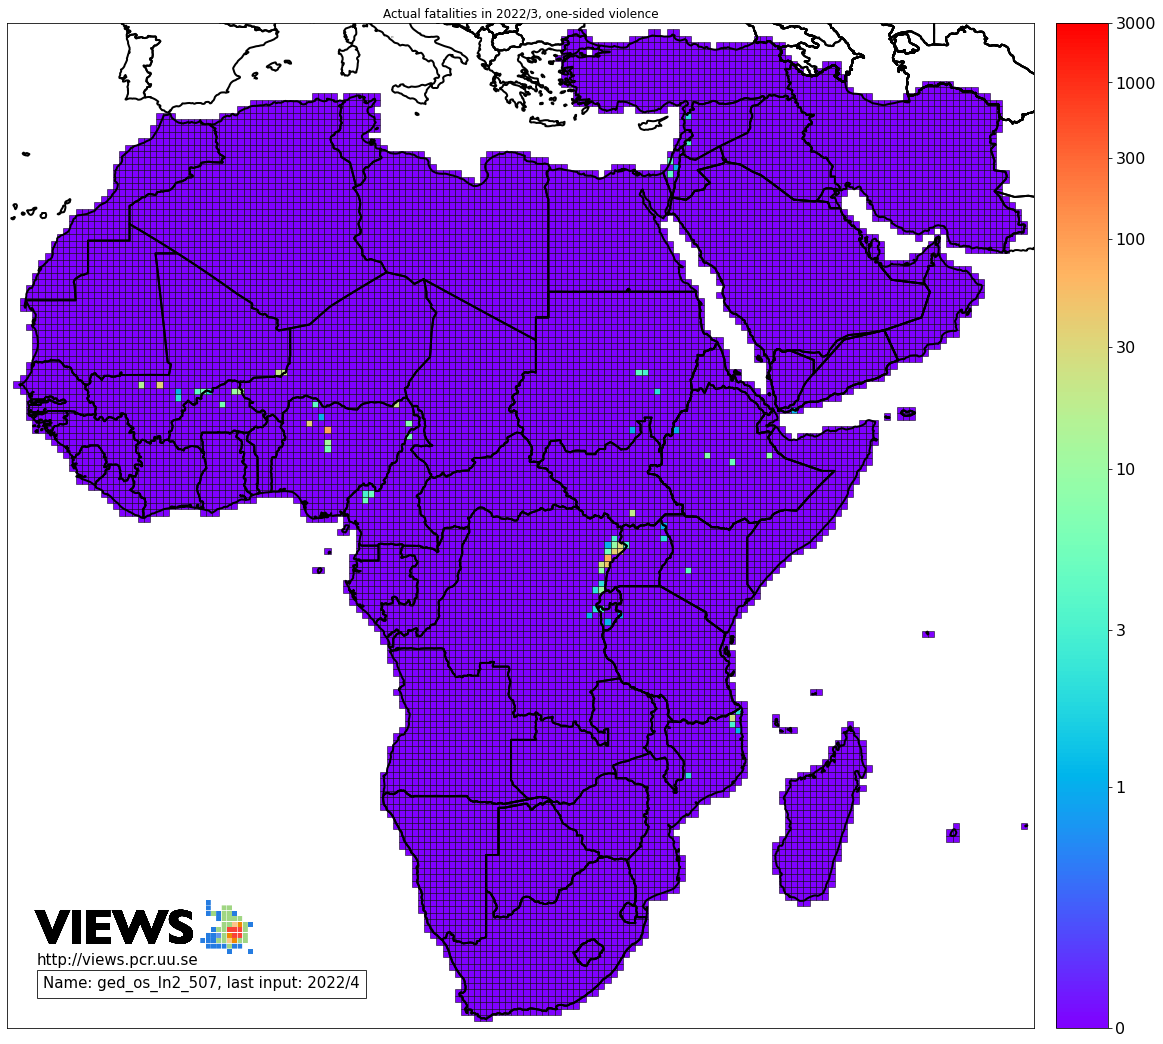

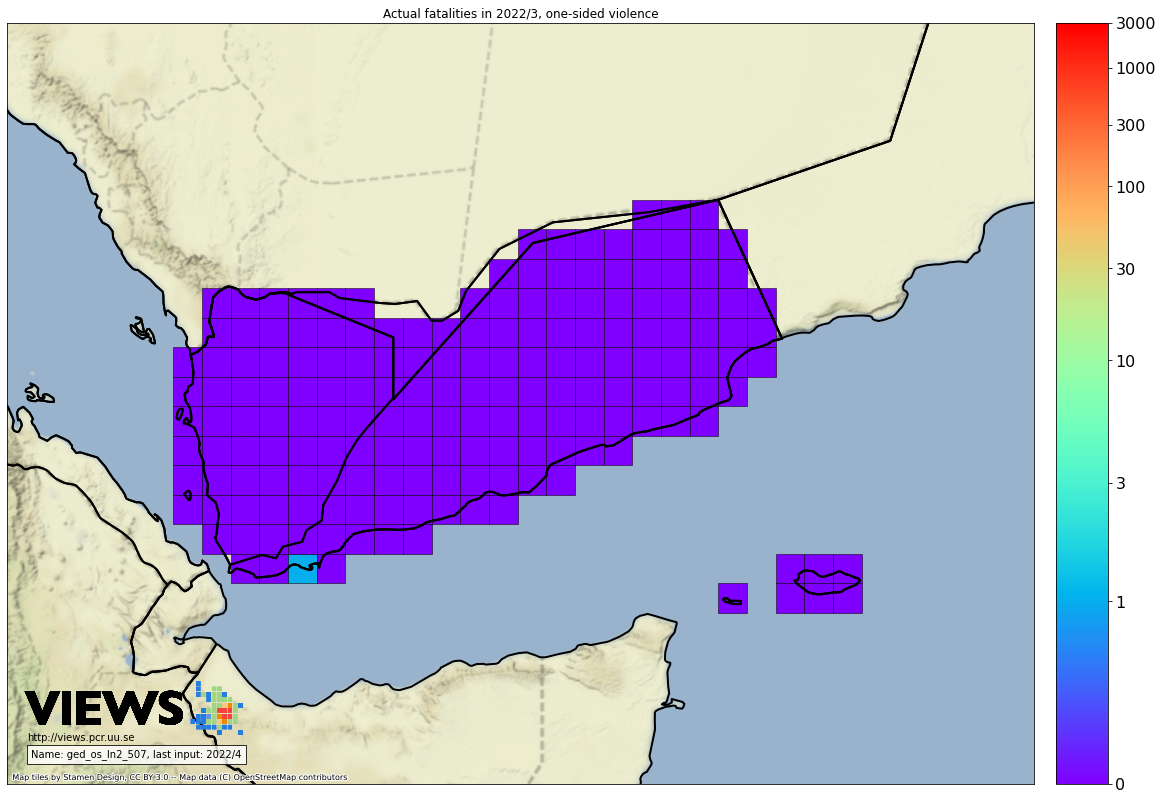

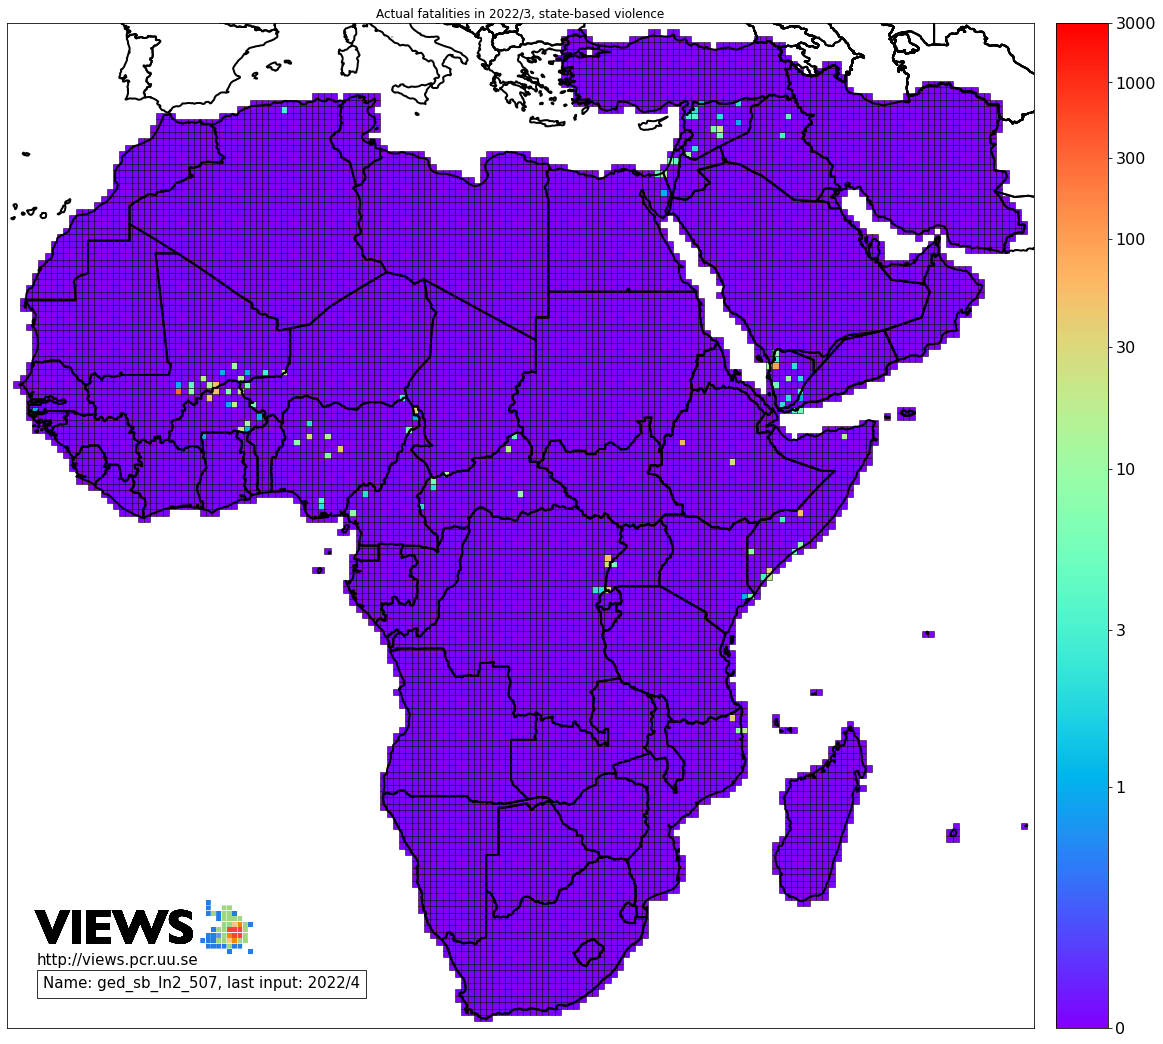

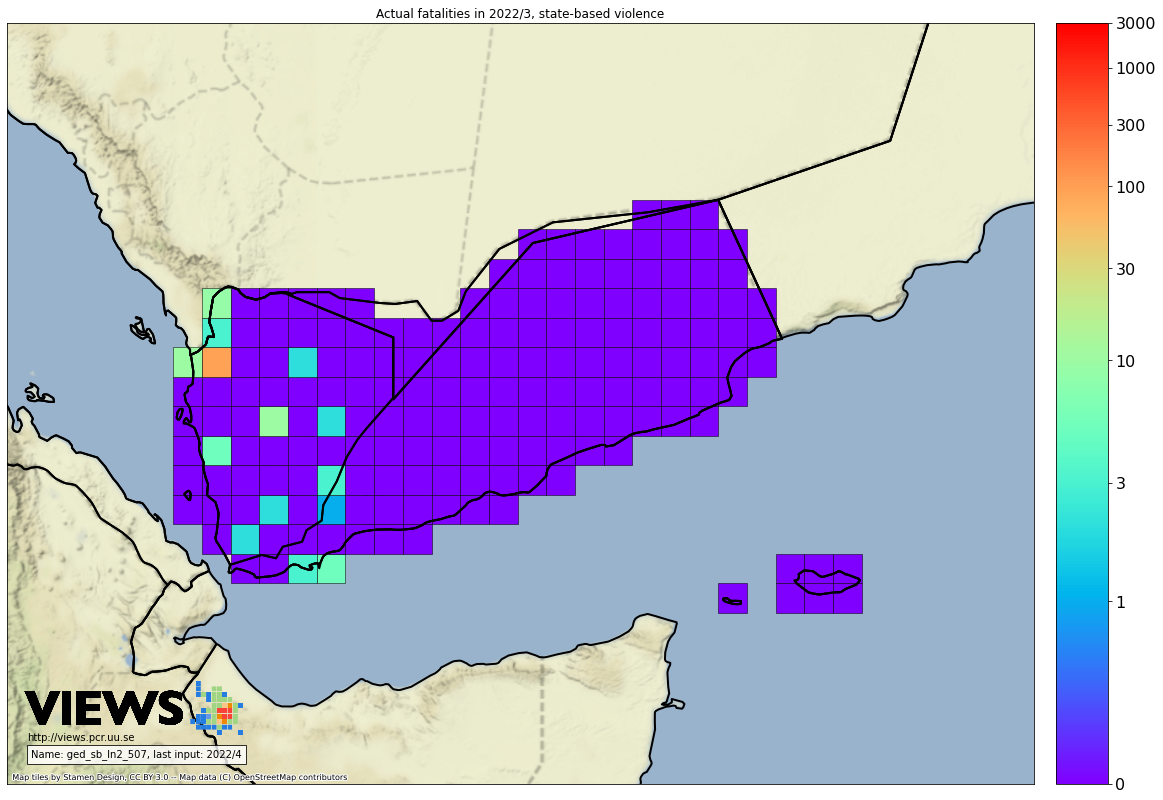

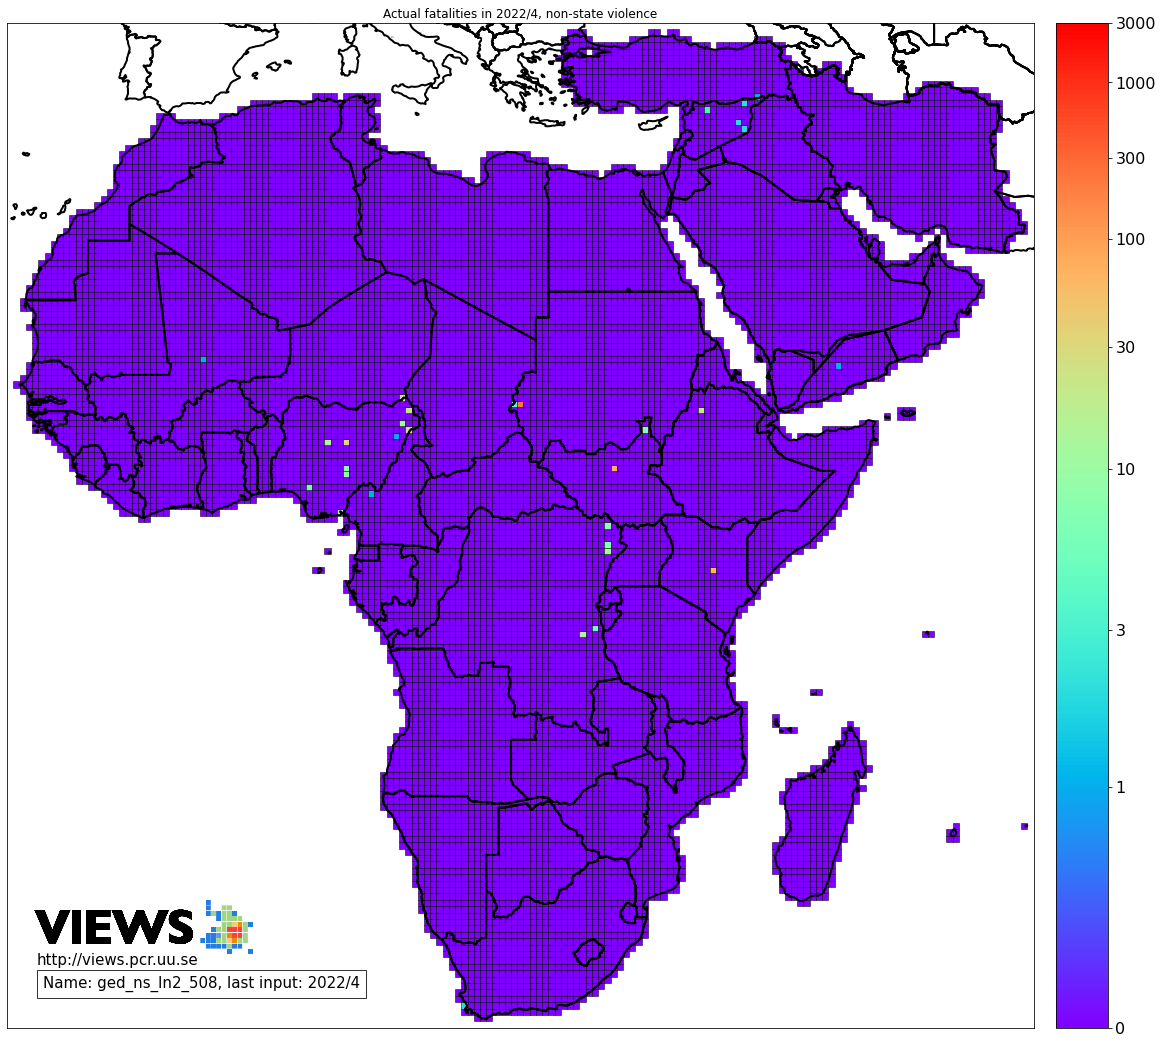

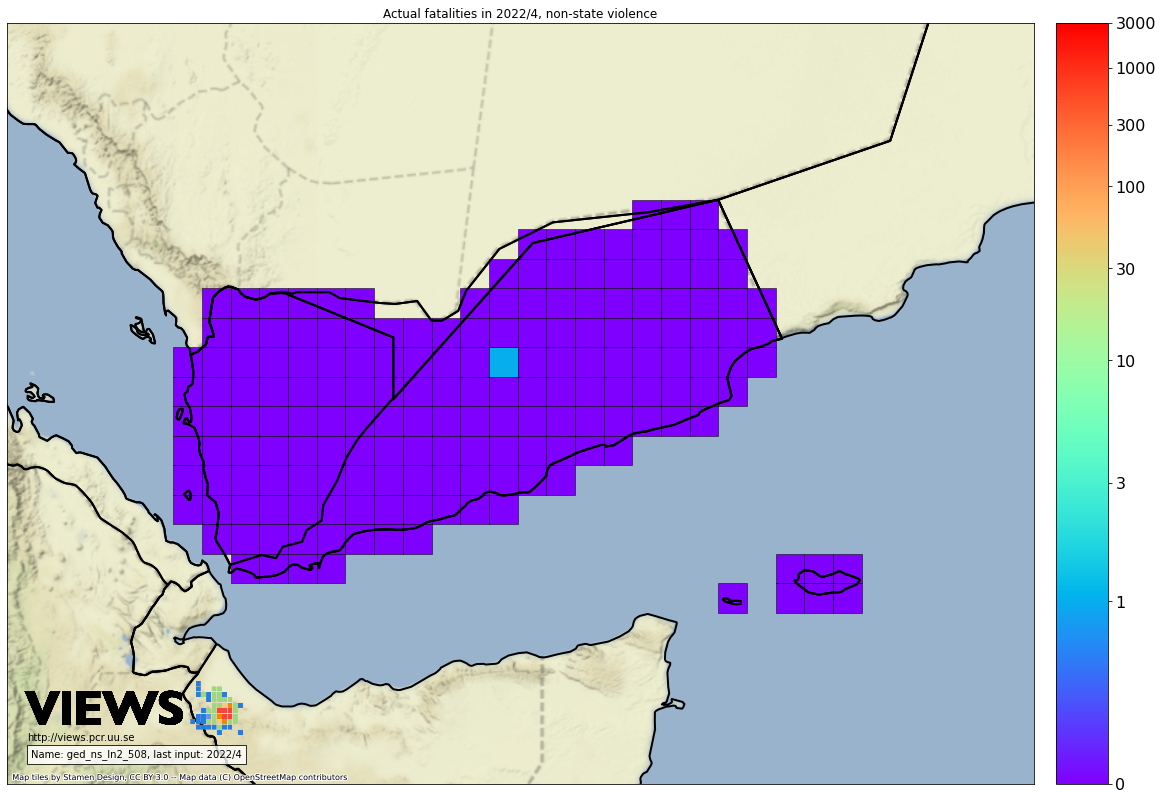

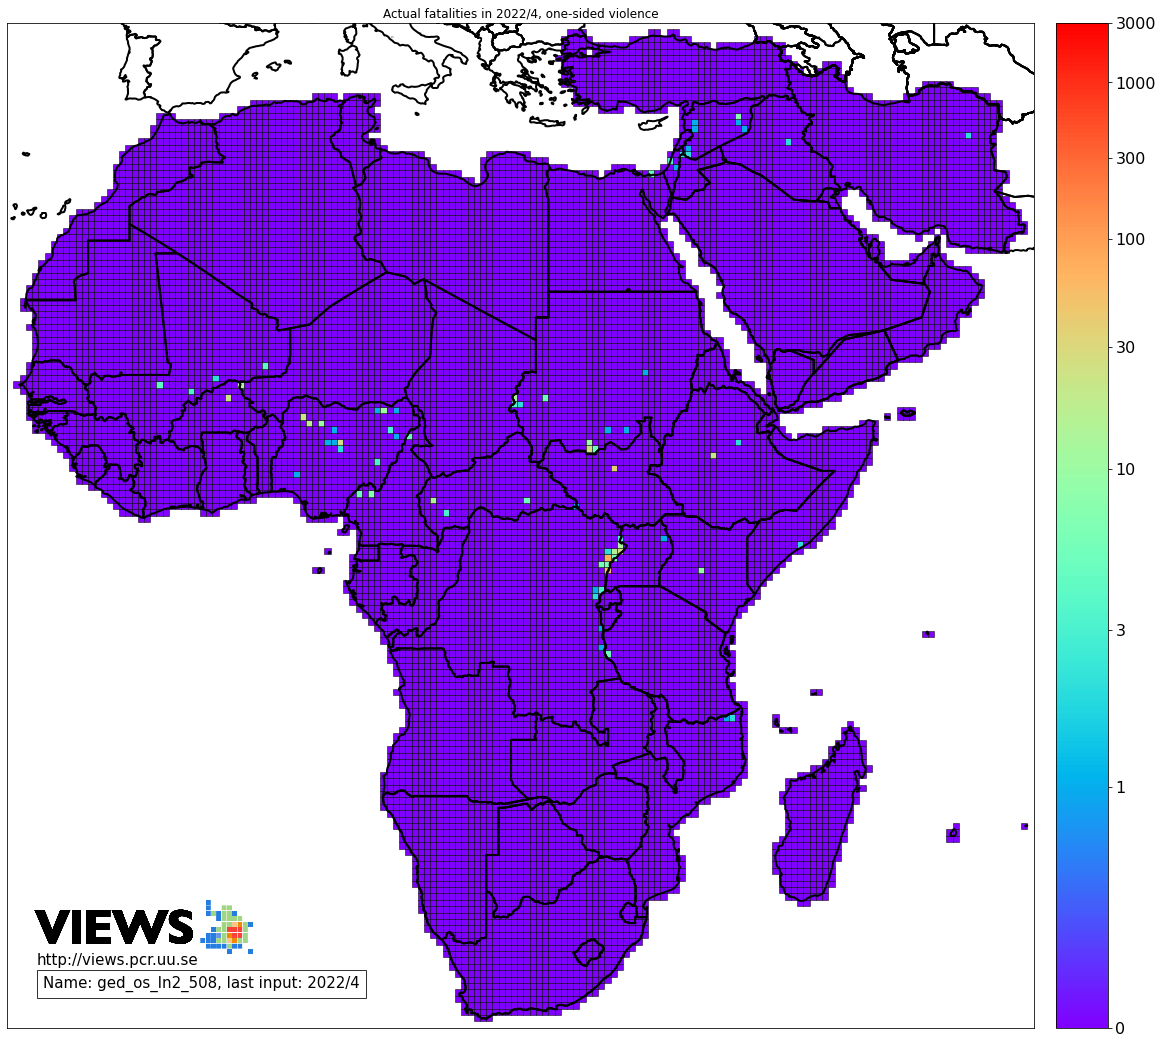

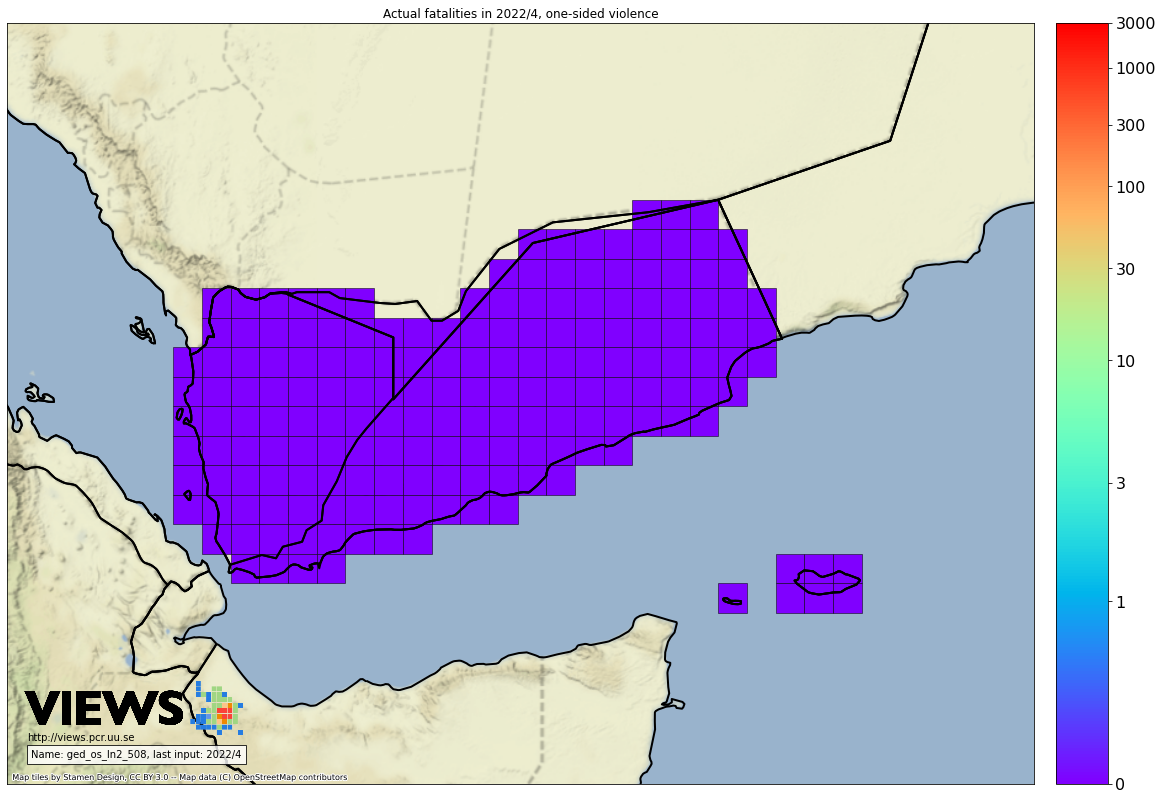

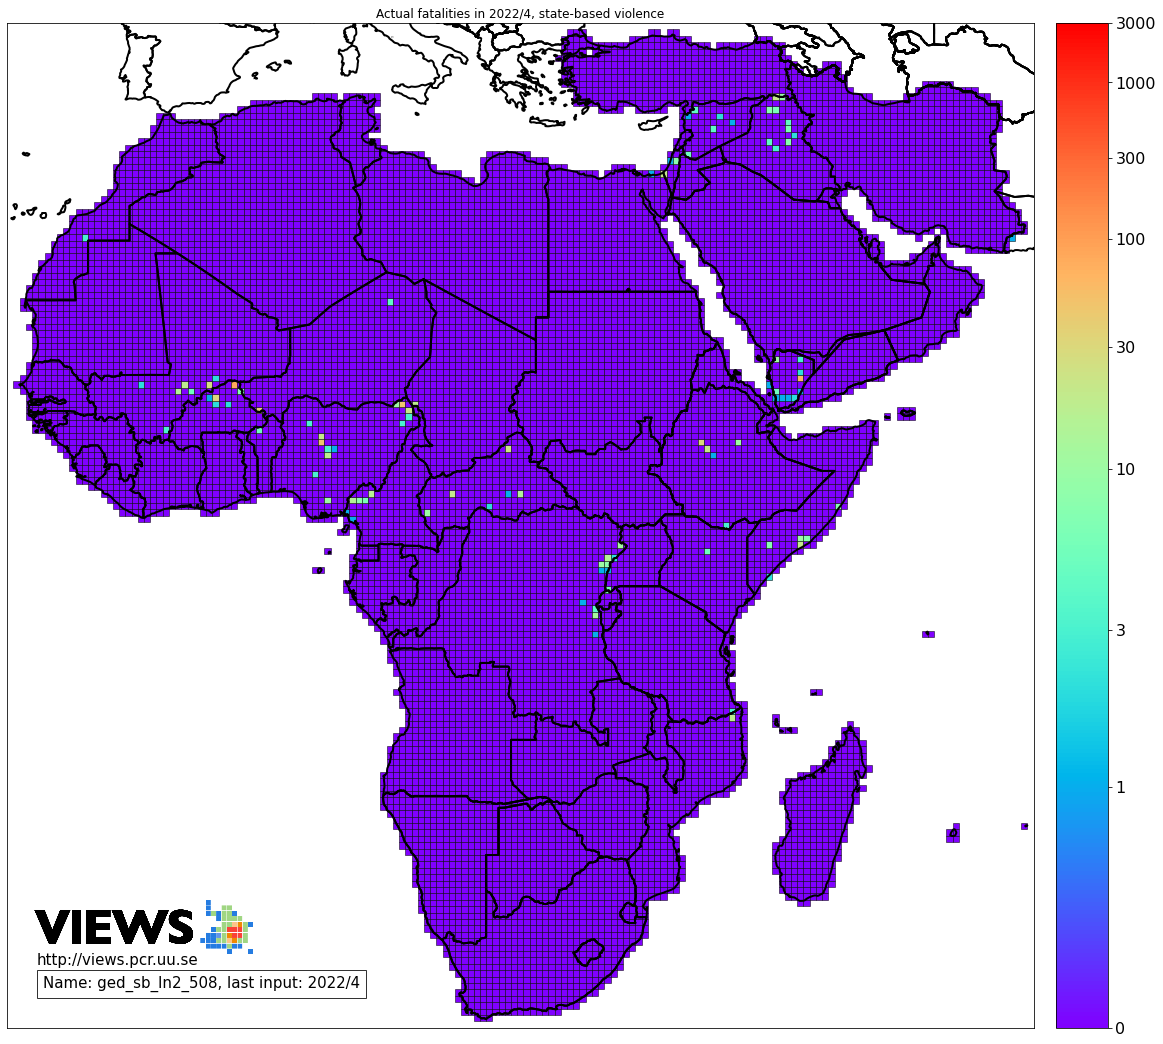

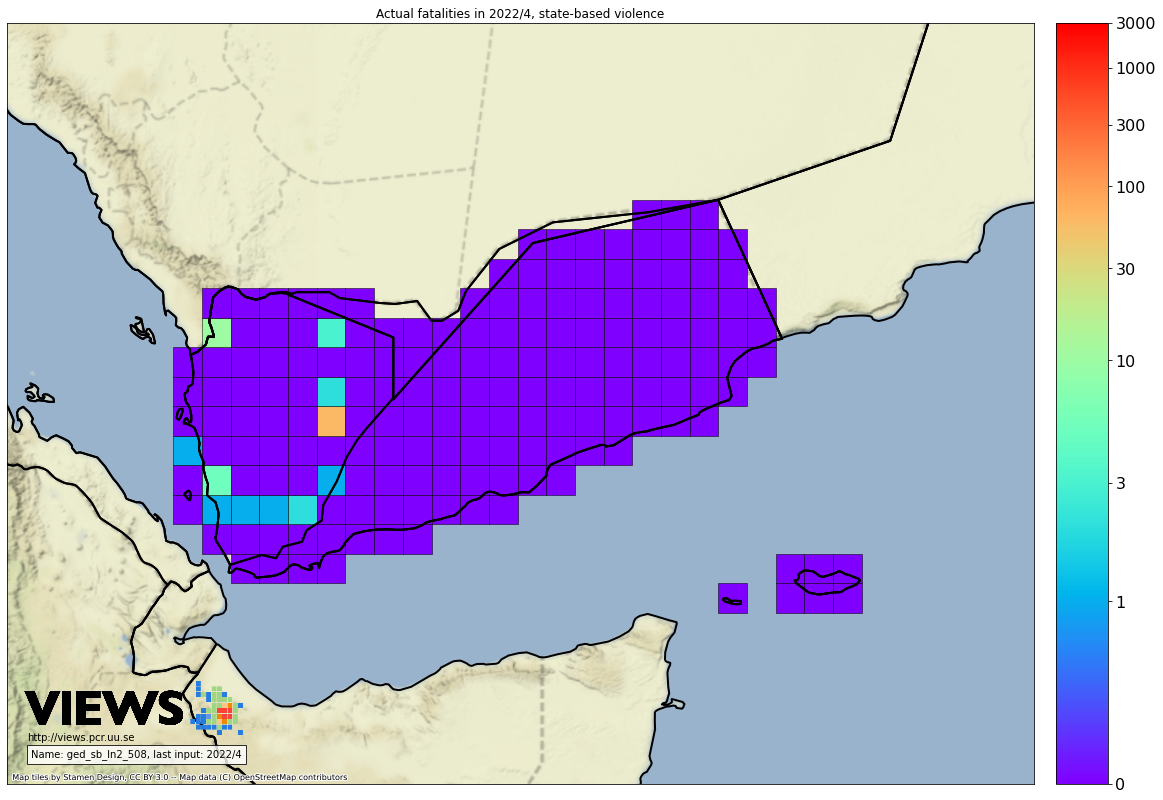

In [15]:
#data preparation
data = features_pgm.copy()
gdf = gdf_pid_master.copy()
data_pid = pd.merge(left = data, right = gdf, left_index = True, right_index = True, how = 'left')
gdf = gpd.GeoDataFrame(data_pid, geometry="geom")
gdf_c = gdf_ci_master.copy()

#savefolder
features_pgm_folder = master_folder+'/Features/Maps/pgm/'

#looping informationa
geo_coverage_loop = ['ame'] + countries_to_map
variable_loop = {'ged_sb_ln2', 'ged_ns_ln2', 'ged_os_ln2'}
steps_loop = {EndOfHistory, EndOfHistory-1}

dictionary_run = dictionary_stand_2p

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
            data_run = gdf.loc[step]
            var_run = variable
            var_name_run = find_the_violence_type(variable)
            var_run_savefile = give_me_violence_string_label_only(variable)
            bbox_run = bbox_from_cid_region(region_name)                       
                        
            #making the choice of textbox size
            if str(region_name) in('globe'):
                textbox_font_size = 10
                masking_run = 'globe'
                background2 = None
            elif str(region_name) in ('ame'):
                textbox_font_size = 20
                masking_run = 'ame'
                background2 = None
            elif str(region_name) in ('africa'):
                textbox_font_size = 20
                masking_run = 'africa'
                background2 = None
            else:
                textbox_font_size = 15
                masking_run = cid2name(region_name)
                background2 = 'StamenTerrainBackground'
                        
            title_run = f'Actual fatalities in {str(vid2date(step))}, {var_name_run}'
            textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
            savefile = f'{features_pgm_folder}GED_pgm{var_run_savefile}_{region_name}_rainbow_month{step}.png'
                  
            masked=Mapper2(
                width=20,
                height=20,
                frame_on=True,
                title=title_run,
                bbox=bbox_run
            ).add_mask(
                gdf = data_run,
                map_dictionary = dictionary_run,
                cmap = 'rainbow',
                transparency = 1,
                masking_location = masking_run,
                column=var_run,
                background = background2,
                edgecolor="black",
                linewidth=0.5
            ).add_views_textbox(
                text=textbox,
                textsize=textbox_font_size)
            
            ax = masked.ax
            masked_with_borders=gdf_c.plot(ax=ax,edgecolor='black',linewidth=2.0,facecolor='None')
                
            plt.savefig(savefile, dpi = 600)
print(f'{user}, pgm maps for ged completed')

## pgm level, features change maps

In [16]:
conf_types=['sb','ns','os']
delta=1 # 1 month
for conf_type in conf_types:
    column='ged_'+conf_type +'_ln1'
    actual=np.exp(features_pgm[column])-1
    shifted=np.exp(features_pgm[column].groupby(level=1).shift(periods=delta))-1    
    
    features_pgm['ln1_delta_'+str(delta)+'_'+column]=np.sign(actual-shifted)*np.log(np.abs(actual-shifted)+1)

In [19]:
features_pgm.columns

Index(['ged_sb_ln1', 'ged_ns_ln1', 'ged_os_ln1', 'ged_sb_ln2', 'ged_ns_ln2',
       'ged_os_ln2', 'ln1_delta_1_ged_sb_ln1', 'ln1_delta_1_ged_ns_ln1',
       'ln1_delta_1_ged_os_ln1'],
      dtype='object')

malika, pgm  change maps for ged completed


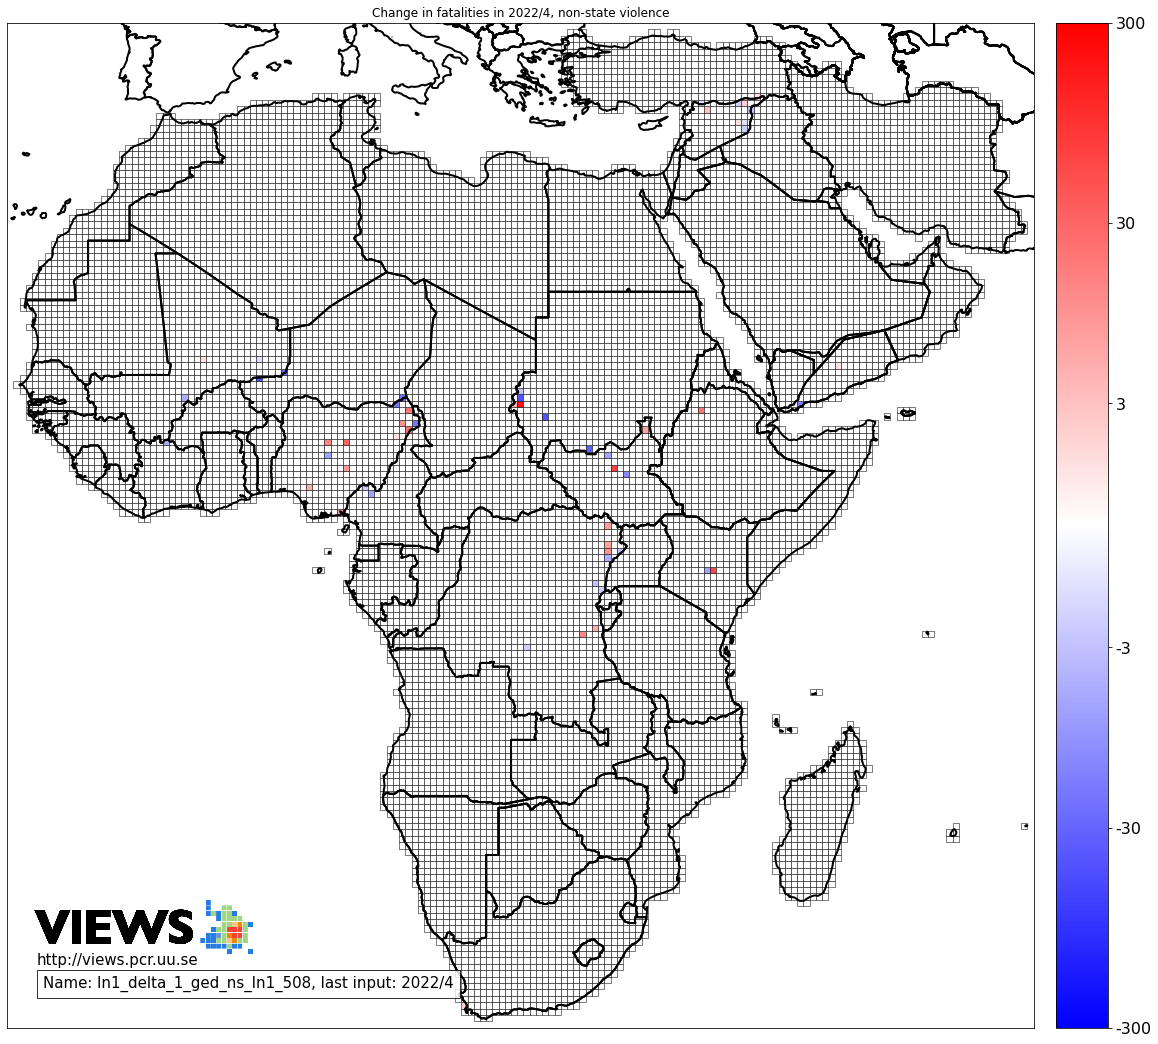

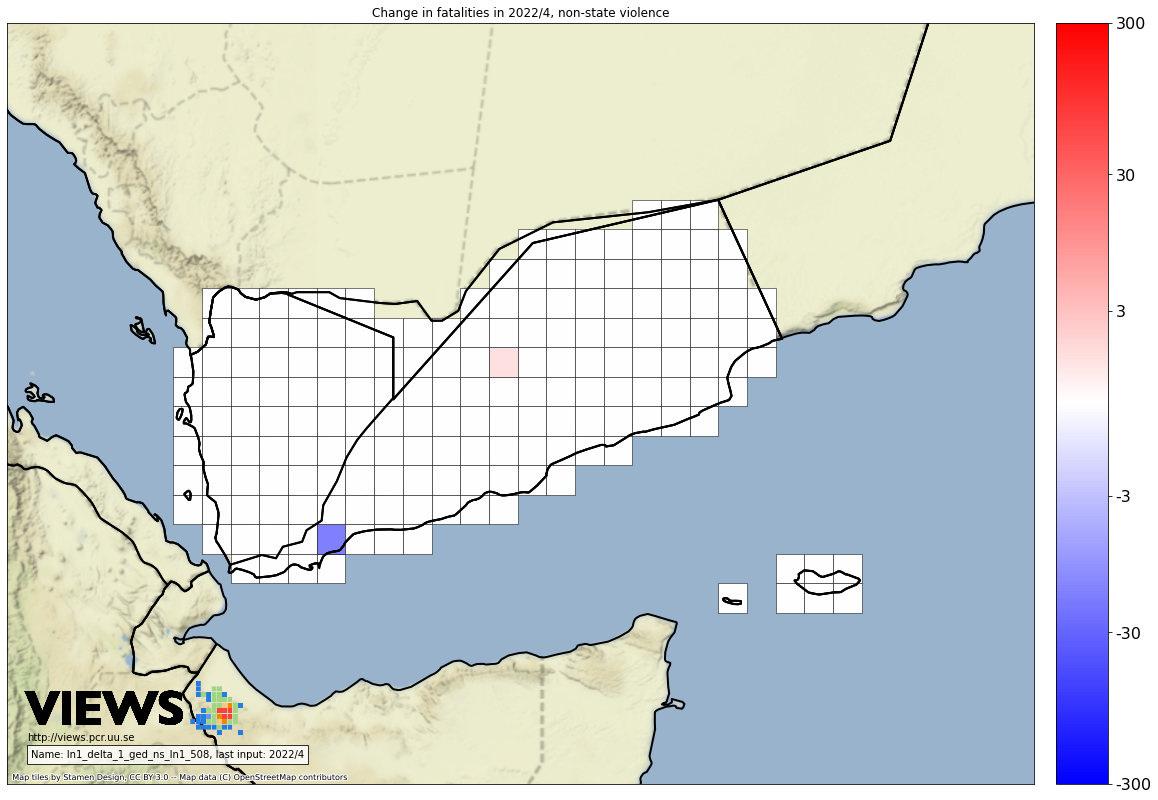

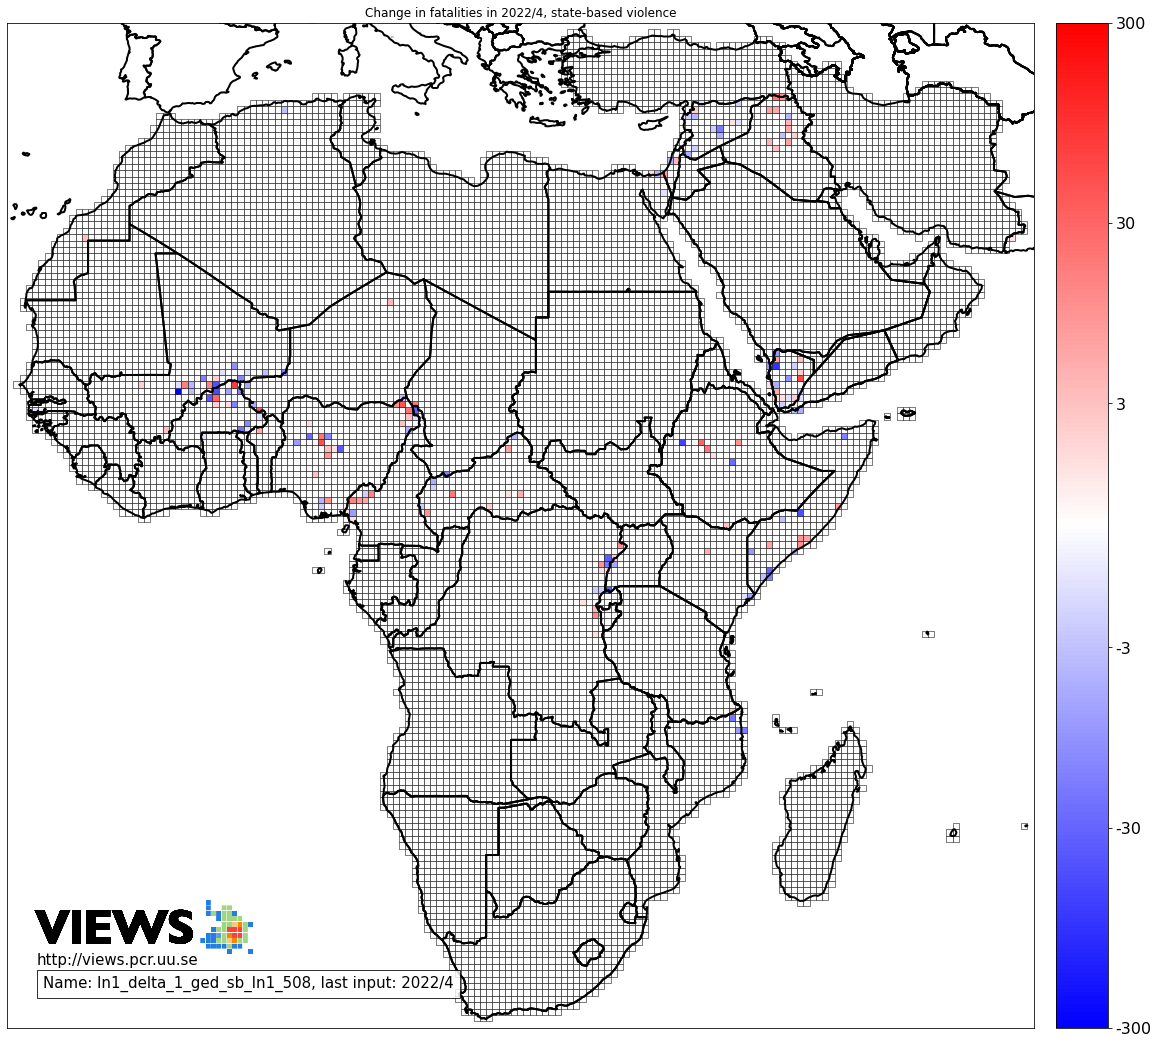

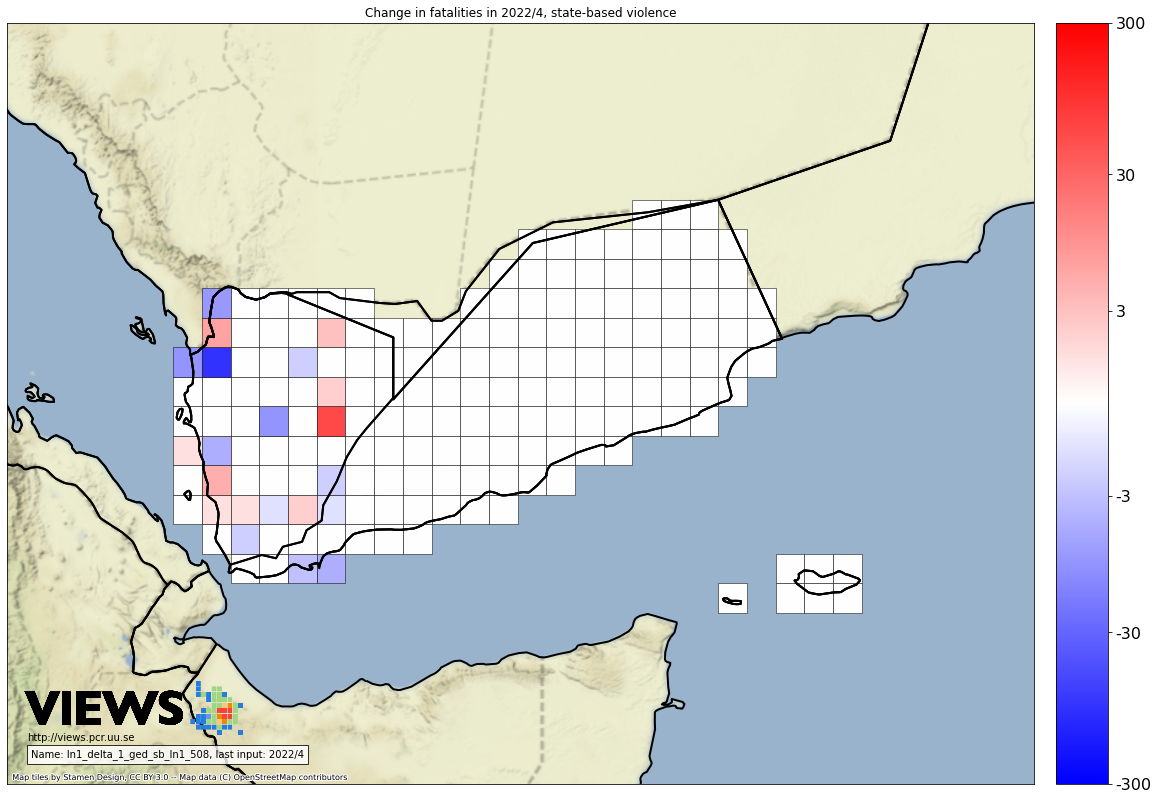

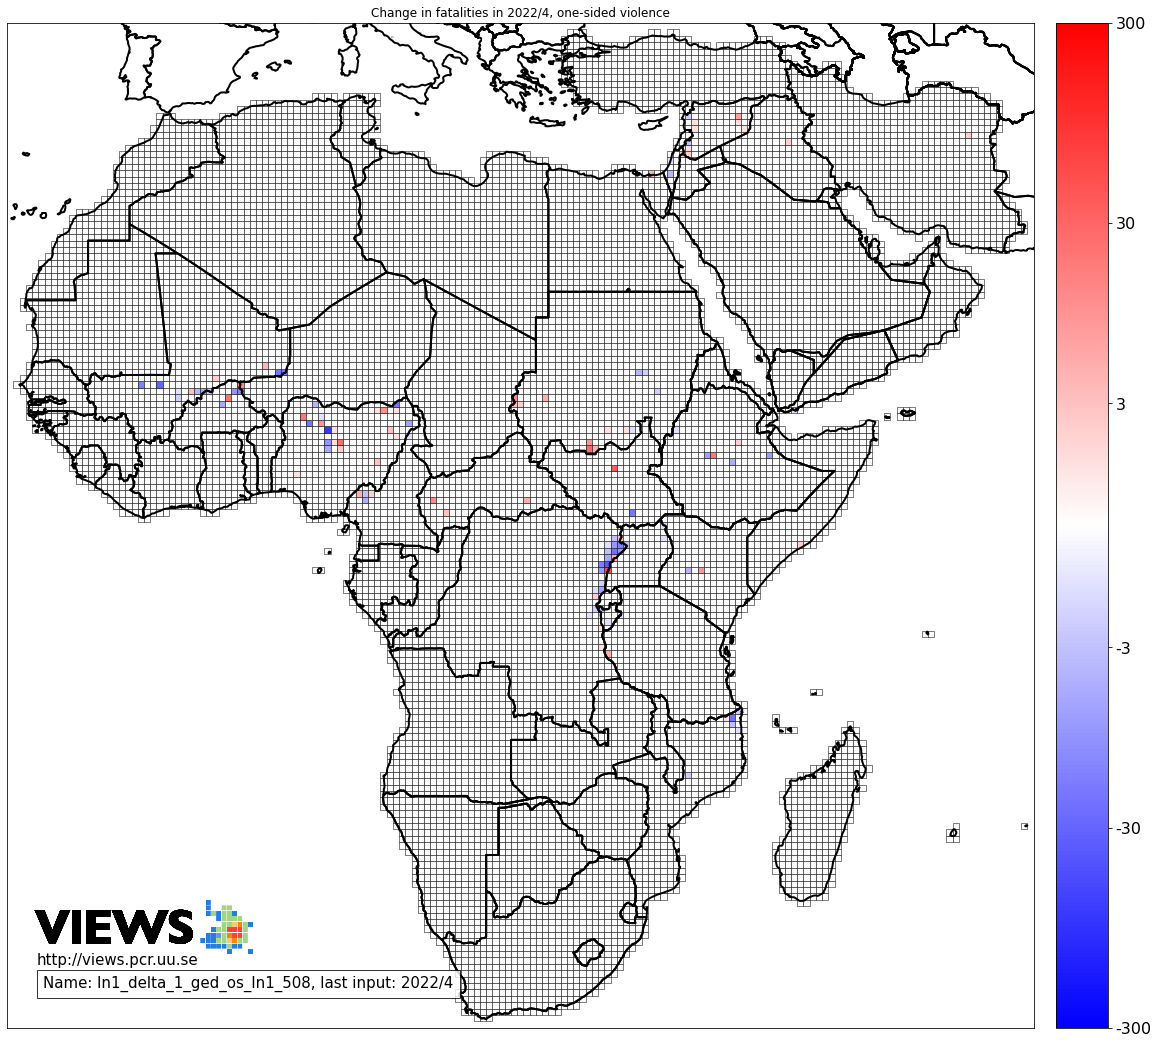

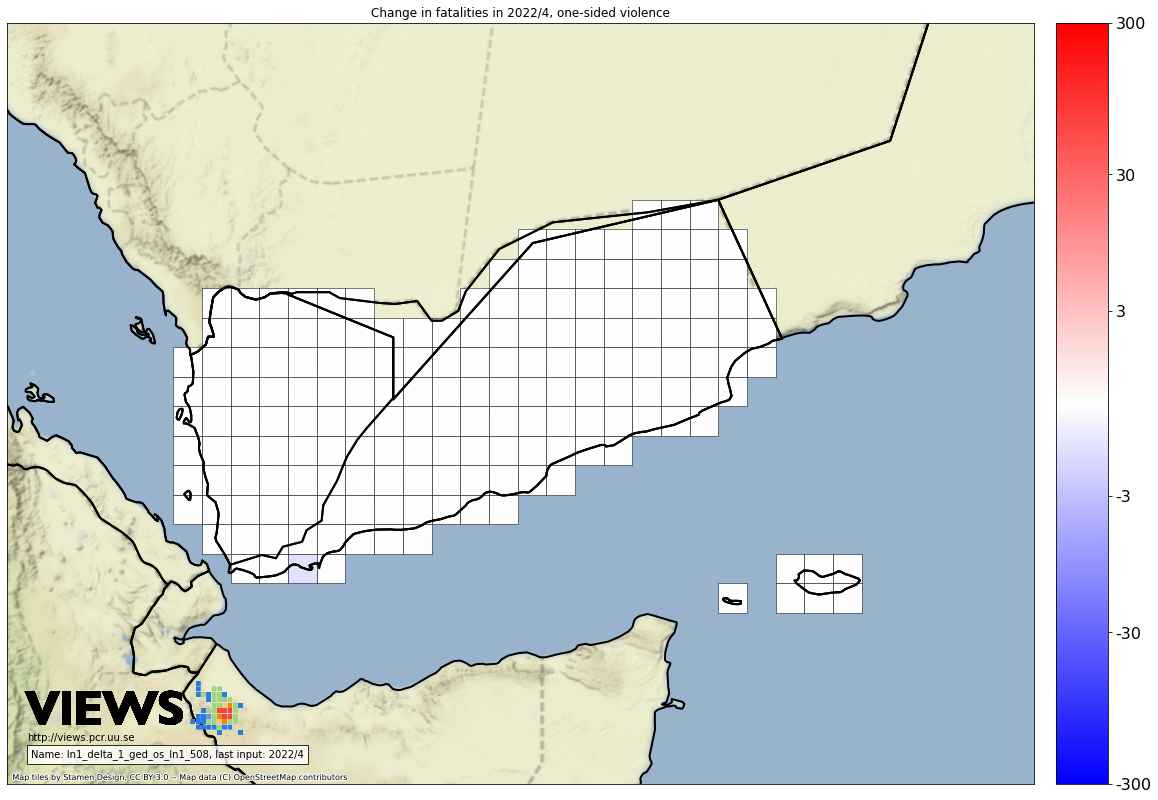

In [20]:
#data preparation
data = features_pgm.copy()
gdf = gdf_pid_master.copy()
data_pid = pd.merge(left = data, right = gdf, left_index = True, right_index = True, how = 'left')
gdf = gpd.GeoDataFrame(data_pid, geometry="geom")
gdf_c = gdf_ci_master.copy()

#savefolder
features_change_pgm_folder = master_folder+'/Features/ChangeMaps/pgm/'

#custom dictionary for this run
change_raw_values = np.array([-300,-30,-3,3,30,300])
change_values = np.sign(change_raw_values)*np.log(np.abs(change_raw_values)+1)
change_ticklabels = [str(tv) for tv in change_raw_values]
change_dictionary = dict(zip(change_ticklabels, change_values))

#looping informationa
geo_coverage_loop = ['ame'] + countries_to_map
variable_loop = {'ln1_delta_1_ged_sb_ln1', 'ln1_delta_1_ged_ns_ln1', 'ln1_delta_1_ged_os_ln1'}
steps_loop = {EndOfHistory}

dictionary_run = change_dictionary

cmap_run = 'bwr'

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
            data_run = gdf.loc[step]
            var_run = variable
            var_name_run = find_the_violence_type(variable)
            var_run_savefile = give_me_violence_string_label_only(variable)
            bbox_run = bbox_from_cid_region(region_name)                       
                        
            #making the choice of textbox size
            if str(region_name) in('globe'):
                textbox_font_size = 10
                masking_run = 'globe'
                background2 = None
            elif str(region_name) in ('ame'):
                textbox_font_size = 20
                masking_run = 'ame'
                background2 = None
            elif str(region_name) in ('africa'):
                textbox_font_size = 20
                masking_run = 'africa'
                background2 = None
            else:
                textbox_font_size = 15
                masking_run = cid2name(region_name)
                background2 = 'StamenTerrainBackground'
                        
            title_run = f'Change in fatalities in {str(vid2date(step))}, {var_name_run}'
            textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
            savefile = f'{features_change_pgm_folder}ChangeMaps_GED_pgm{var_run_savefile}_{region_name}_month{step}.png'
                  
            masked=Mapper2(
                width=20,
                height=20,
                frame_on=True,
                title=title_run,
                bbox=bbox_run
            ).add_mask(
                gdf = data_run,
                map_dictionary = dictionary_run,
                cmap = cmap_run,
                transparency = 1,
                masking_location = masking_run,
                column=var_run,
                background = background2,
                edgecolor="black",
                linewidth=0.5
            ).add_views_textbox(
                text=textbox,
                textsize=textbox_font_size)
            
            ax = masked.ax
            masked_with_borders=gdf_c.plot(ax=ax,edgecolor='black',linewidth=2.0,facecolor='None')
                
            plt.savefig(savefile, dpi = 600)
print(f'{user}, pgm  change maps for ged completed')

# Prediction maps, cm level

## Continuous and dictotomous mapping at step 3 and 6

In [305]:
#Read in future predictions at cm level as given by the parameters above
#note that the output step combined is already log transformed

predstore_future = level_cm +  '_' + 'genetic_ensemble' + '_f' + str(EndOfHistory)
predstore_future_dich = level_cm +  '_' + 'genetic_ensemble' + '_dich_f' + str(EndOfHistory)

predictions_df = pd.DataFrame.forecasts.read_store(predstore_future, run=dev_id_cm)
predictions_dich_df = pd.DataFrame.forecasts.read_store(predstore_future_dich, run=dev_id_cm)

#Redefine month_id into steps as a index, change the name of some variables for consistency/workability with code
#note step combined is already a log transformed variable that uses state-based violence
predictions_df = predictions_df.reset_index()
predictions_df['step'] = predictions_df['month_id'] - EndOfHistory
predictions_df = predictions_df.set_index(['step', 'country_id'], drop = True)
predictions_df['ln1_step_combined_sb'] = predictions_df['step_combined']
predictions_df['ln2_step_combined_sb'] = np.log1p(predictions_df['ln1_step_combined_sb'])

#predictions_dich_df gives state based violence
predictions_dich_df = predictions_dich_df.reset_index()
predictions_dich_df['step'] = predictions_dich_df['month_id'] - EndOfHistory
predictions_dich_df = predictions_dich_df.set_index(['step', 'country_id'], drop = True)
predictions_dich_df['step_combined_sb'] = predictions_dich_df['step_combined']

print(f'{user}, prediction data at cm level successfully fetched')

pr_45_cm_genetic_ensemble_f508.parquet
pr_45_cm_genetic_ensemble_dich_f508.parquet
malika, prediction data at cm level successfully fetched


In [339]:
predictions_df

feature          month_id  step_combined  ln1_step_combined_sb  \
step country_id                                                  
1    1                509       0.026422              0.026422   
     2                509       0.005349              0.005349   
     3                509       0.004348              0.004348   
     4                509       0.614890              0.614890   
     5                509       0.004200              0.004200   
...                   ...            ...                   ...   
36   242              544       1.171913              1.171913   
     243              544       1.166257              1.166257   
     244              544       0.214822              0.214822   
     245              544       2.449034              2.449034   
     246              544       3.217123              3.217123   

feature          ln2_step_combined_sb  
step country_id                        
1    1                       0.026079  
     2                       0.005335  
     3                       0.004339  
     4                       0.479267  
     5                       0.004192  
...                               ...  
36   242                     0.775608  
     243                     0.773001  
     244                     0.194597  
     245                     1.238094  
     246                     1.439153  

[6876 rows x 4 columns]

In [22]:
#for predictions, we are interested in steps 3 and 6

#prep data
data= predictions_df.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#savefolder
predictions_cm_folder = master_folder+'/Continuous/Ensemble/ForecastMaps/cm/'

#looping informationa
geo_coverage_loop = ['globe', 'ame'] + countries_to_map
variable_loop = {'ln2_step_combined_sb'}
steps_loop = {3, 6}

dictionary_run = dictionary_stand_2p_10k

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
            data_run = gdf.loc[step]
            var_run = variable
            var_name_run = find_the_violence_type(variable)
            var_run_savefile = give_me_violence_string_label_only(variable)
            bbox_run = bbox_from_cid_region(region_name)
            month_id = step+EndOfHistory
                        
            #making the choice of textbox size
            if str(region_name) in('globe'):
                textbox_font_size = 10
            elif str(region_name) in ('ame', 'africa'):
                textbox_font_size = 20
            else:textbox_font_size = 15
                        
            title_run = f'Predicted fatalities in {str(vid2date(month_id))}, {var_name_run}'
            textbox = f'Name: {var_run}_step{str(step)}, last input: {str(vid2date(EndOfHistory))}'
            savefile = f'{predictions_cm_folder}{dev_id_cm}{var_run_savefile}_{region_name}_rainbow_step{step}.png'
            
            if region_name in ('globe', 'ame', 'africa'):
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_layer(
                    gdf=data_run,
                    map_dictionary=dictionary_run,
                    cmap='binary',
                    edgecolor="black",
                    linewidth=0.5,
                    transparency = 1.0,
                    column=var_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = 'rainbow',
                    transparency = 1,
                    masking_location = region_name,
                    column=var_run,
                    edgecolor="black",
                    linewidth=1
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
            else:
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = 'rainbow',
                    transparency = 0.8,
                    background = 'OpenStreetMap',
                    masking_location = str(cid2name(region_name)),
                    column=var_run,
                    edgecolor="black",
                    linewidth=1, 
                    views_experimental_labels = 15
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
print(f'{user}, cm prediction maps completed')

malika, cm prediction maps completed


In [23]:
#making a custom dictionary for dichotomous outcomes from 0-1
dich_values=np.array([0,0.2,0.4,0.6,0.8,1.0])
dich_ticklabels=[str(tv) for tv in dich_values]
dich_dictionary = dict(zip(dich_ticklabels, dich_values))

In [25]:
#maps of the dichotomous predictions
#for predictions, we are interested in steps 3 and 6

#prep data
data= predictions_dich_df.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#savefolder
predictions_dich_cm_folder = master_folder+'/Dichotomous/Ensemble/ForecastMaps/cm/'

#looping informationa
geo_coverage_loop = ['globe', 'ame'] + countries_to_map
variable_loop = {'step_combined_sb'}
steps_loop = {3, 6}

dictionary_run = dich_dictionary


for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
            data_run = gdf.loc[step]
            var_run = variable
            var_name_run = find_the_violence_type(variable)
            var_run_savefile = give_me_violence_string_label_only(variable)
            bbox_run = bbox_from_cid_region(region_name)
            month_id = step+EndOfHistory
                        
            #making the choice of textbox size
            if str(region_name) in('globe'):
                textbox_font_size = 10
            elif str(region_name) in ('ame', 'africa'):
                textbox_font_size = 20
            else:textbox_font_size = 15
                        
            title_run = f'Predicted dichtomous fatalities in {str(vid2date(month_id))}, {var_name_run}'
            textbox = f'Name: {var_run}_step{str(step)}, last input: {str(vid2date(EndOfHistory))}'
            savefile = f'{predictions_dich_cm_folder}{dev_id_cm}{var_run_savefile}_{region_name}_rainbow_step{step}.png'
            
            if region_name in ('globe', 'ame', 'africa'):
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_layer(
                    gdf=data_run,
                    map_dictionary=dictionary_run,
                    cmap='binary',
                    edgecolor="black",
                    linewidth=0.5,
                    transparency = 1.0,
                    column=var_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = 'rainbow',
                    transparency = 1,
                    masking_location = region_name,
                    column=var_run,
                    edgecolor="black",
                    linewidth=1
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
            else:
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = 'rainbow',
                    transparency = 0.8,
                    background = 'OpenStreetMap',
                    masking_location = str(cid2name(region_name)),
                    column=var_run,
                    edgecolor="black",
                    linewidth=1, 
                    views_experimental_labels = 15
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
print(f'{user}, cm dich prediction maps completed')

malika, cm dich prediction maps completed


## Continuous and dichotomous mapping at cm level, change

Note for this case, there are several ways to interpret change maps
Version 1: compare step n with step n of previous run
Version 2: compare month n with month n of previous run
Version 3: compare step 1 with the average running of the actuals for step 0 (EndOfHistory)

### Data preparation

In [296]:
predictions_df_old

feature  step  country_id  month_id  ln1_sb_old_pred_step  \
0           1           1       508              0.005760   
1           1           2       508              0.005011   
2           1           3       508              0.004398   
3           1           4       508              0.870821   
4           1           5       508              0.004191   
...       ...         ...       ...                   ...   
6871       36         242       543              1.151057   
6872       36         243       543              0.937526   
6873       36         244       543              0.241870   
6874       36         245       543              2.528440   
6875       36         246       543              2.973675   

feature  ln1_sb_old_pred_month  
0                     0.005760  
1                     0.005011  
2                     0.004398  
3                     0.870821  
4                     0.004191  
...                        ...  
6871                  1.151057  
6872                  0.937526  
6873                  0.241870  
6874                  2.528440  
6875                  2.973675  

[6876 rows x 5 columns]

In [309]:
# in this case, I am comparing two runs together
#first obtain a previous/old run

predstore_future_old = level_cm +  '_' + 'genetic_ensemble' + '_f' + str(EndOfHistory-1)
predstore_future_dich_old = level_cm +  '_' + 'genetic_ensemble' + '_dich_f' + str(EndOfHistory-1)

predictions_df_old = pd.DataFrame.forecasts.read_store(predstore_future_old, run=dev_id_cm_old)
predictions_dich_df_old = pd.DataFrame.forecasts.read_store(predstore_future_dich_old, run=dev_id_cm_old)

#Redefine month_id into steps as a index, change the name of some variables for consistency/workability with code
#note step combined is already a log transformed variable that uses state-based violence
predictions_df_old = predictions_df_old.reset_index()
predictions_df_old['step'] = predictions_df_old['month_id'] - (EndOfHistory -1)
predictions_df_old = predictions_df_old.set_index(['step', 'country_id'], drop = True)
predictions_df_old['ln1_sb_old_pred_step'] = predictions_df_old['step_combined']
predictions_df_old['ln1_sb_old_pred_month'] = predictions_df_old['step_combined']
predictions_df_old = predictions_df_old[predictions_df_old.columns[predictions_df_old.columns.isin(['month_id', 'ln1_sb_old_pred_step', 'ln1_sb_old_pred_month'])]]
predictions_df_old = predictions_df_old.reset_index()
predictions_df_old_step = predictions_df_old[predictions_df_old.columns[predictions_df_old.columns.isin(['step', 'country_id', 'ln1_sb_old_pred_step'])]].set_index('step', 'country_id')
predictions_df_old_month = predictions_df_old[predictions_df_old.columns[predictions_df_old.columns.isin(['month_id', 'country_id', 'ln1_sb_old_pred_month'])]].set_index('month_id', 'country_id')

#predictions_dich_df gives state based violence
predictions_dich_df_old = predictions_dich_df_old.reset_index()
predictions_dich_df_old['step'] = predictions_dich_df_old['month_id'] - (EndOfHistory -1)
predictions_dich_df_old = predictions_dich_df_old.set_index(['step', 'country_id'], drop = True)
predictions_dich_df_old['dich_pred_sb_step'] = predictions_dich_df_old['step_combined']
predictions_dich_df_old['dich_pred_sb_month'] = predictions_dich_df_old['step_combined']
predictions_dich_df_old = predictions_dich_df_old.reset_index()
predictions_dich_df_old_step = predictions_dich_df_old[predictions_dich_df_old.columns[predictions_dich_df_old.columns.isin(['step', 'country_id', 'dich_pred_sb_step'])]].set_index('step', 'country_id')
predictions_dich_df_old_month = predictions_dich_df_old[predictions_dich_df_old.columns[predictions_dich_df_old.columns.isin(['month_id', 'country_id', 'dich_pred_sb_month'])]].set_index('month_id', 'country_id')


print(f'{user}, prediction data from previous month at cm level successfully fetched')

pr_45_cm_genetic_ensemble_f507.parquet
pr_45_cm_genetic_ensemble_dich_f507.parquet
malika, prediction data from previous month at cm level successfully fetched


In [192]:
running_average_qs = (Queryset("Monthly_update_running_average_cm", "country_month")


    # target variable
    .with_column(Column("ged_sb_run_average_6_ln1", from_table = "ged2_cm", from_column = "ged_sb_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.temporal.moving_average(6)
        .transform.ops.ln()
        )
      .with_column(Column("ged_ns_run_average_6_ln1", from_table = "ged2_cm", from_column = "ged_ns_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.temporal.moving_average(6)
        .transform.ops.ln()
        )
      .with_column(Column("ged_os_run_average_6_ln1", from_table = "ged2_cm", from_column = "ged_os_best_sum_nokgi")
        .transform.missing.replace_na()
        .transform.temporal.moving_average(6)
        .transform.ops.ln()
        )
                
    .with_theme("monthly_update")
                         
            .describe("""Features for the monthly report""")
    )
              

running_average_master=running_average_qs.publish().fetch()

print(f'{user} cm_running_average fetched successfully')

 .    malika cm_running_average fetched successfully


In [306]:
running_average = running_average_master.copy()
running_average = running_average.query(f'month_id == {EndOfHistory}')
running_average = running_average.reset_index()
running_average = running_average[running_average.columns[running_average.columns.isin(['country_id', 'ged_sb_run_average_6_ln1','ged_ns_run_average_6_ln1', 'ged_os_run_average_6_ln1'])]]

In [307]:
temp1 = pd.merge(predictions_df.reset_index(), running_average, left_on = 'country_id', right_on = 'country_id', how = 'left')
temp2 = pd.merge(temp1, predictions_df_old_step, left_on = ('step', 'country_id'), right_on = ('step', 'country_id'), how= 'left').reset_index()
change_cm_master = pd.merge(temp2, predictions_df_old_month, left_on = ('month_id', 'country_id'), right_on = ('month_id', 'country_id'), how= 'left').reset_index()
change_cm_master = change_cm_master.drop(columns = ['level_0', 'index'])

In [333]:
#creating change variables

change_cm = change_cm_master.copy()
conf_types=['sb']
#conf_types=['sb','ns','os'] #for when we add other types of violence

for conf_type in conf_types:
    #this is for comparison of predictions vs. running average at endofhistory
    column_prediction='ln1_step_combined_'+conf_type
    column_comparison = 'ged_' +conf_type+'_run_average_6_ln1'
    actual_prediction=np.exp(change_cm[column_prediction])-1
    actual_comparison = np.exp(change_cm[column_comparison]) -1
    change_cm ['change_from_running_average_ln1'] = np.sign(actual_prediction - actual_comparison) * np.log(np.abs(actual_prediction-actual_comparison)+1)
    
    #this is for comparison vs. matching step from old prediction run
    column_comparison2 = 'ln1_' + conf_type + '_old_pred_step'
    actual_comparison2 = np.exp(change_cm[column_comparison2])-1
    change_cm ['change_at_same_step_ln1'] = np.sign(actual_prediction - actual_comparison2) * np.log(np.abs(actual_prediction-actual_comparison2)+1)
    
    #this is for comparison vs. matching month from old prediction run
    column_comparison3 = 'ln1_' + conf_type + '_old_pred_month'
    actual_comparison3 = np.exp(change_cm[column_comparison3])-1
    change_cm ['change_at_same_month_ln1'] = np.sign(actual_prediction - actual_comparison3) * np.log(np.abs(actual_prediction-actual_comparison3)+1)

change_cm = change_cm.set_index(['step', 'country_id'])
    
print(f'{user}, change for cm continuous data successfully produced')


malika, change for cm continuous data successfully produced


In [334]:
#same for dichotomous, note there is no running average comparison for dichotomous outcome, so only predictions steps and months
temp1 = pd.merge(predictions_dich_df.reset_index(), predictions_dich_df_old_step,left_on = ('step', 'country_id'), right_on = ('step', 'country_id'), how= 'left').reset_index()
change_cm_dich_master = pd.merge(temp1, predictions_dich_df_old_month,left_on = ('month_id', 'country_id'), right_on = ('month_id', 'country_id'), how= 'left').reset_index()
change_cm_dich_master = change_cm_dich_master.drop(columns = ['level_0', 'index'])

In [327]:
#creating change variables

change_cm_dich = change_cm_dich_master.copy()
conf_types=['sb']
#conf_types=['sb','ns','os'] #for when we add other types of violence

for conf_type in conf_types:
    
    #this is for comparison vs. matching step from old prediction run
    column_prediction = 'step_combined_' + conf_type
    column_comparison1 = 'dich_pred_' + conf_type+'_step'
    
    actual_prediction = change_cm_dich[column_prediction]
    actual_comparison1 = change_cm_dich[column_comparison1]

    change_cm_dich ['change_at_same_step'] = actual_prediction - actual_comparison1
    
    #this is for comparison vs. matching month from old prediction run
    column_comparison2 = 'dich_pred_' + conf_type+'_month'
    actual_comparison2 = change_cm_dich[column_comparison2]
    change_cm_dich ['change_at_same_month'] = actual_prediction - actual_comparison2

change_cm_dich = change_cm_dich.set_index(['step', 'country_id'])
    
print(f'{user}, change for cm dichotomous data successfully produced')

malika, change for cm dichotomous data successfully produced


### Continous change maps mapping

In [332]:
change_dictionary

{'-300': -5.707110264748875,
 '-30': -3.4339872044851463,
 '-3': -1.3862943611198906,
 '3': 1.3862943611198906,
 '30': 3.4339872044851463,
 '300': 5.707110264748875}

In [336]:
change_cm.describe()

month_id  step_combined  ln1_step_combined_sb  ln2_step_combined_sb  \
count  6876.00000    6876.000000           6876.000000           6876.000000   
mean    526.50000       0.748832              0.748832              0.365813   
std      10.38905       1.421543              1.421543              0.541899   
min     509.00000      -0.019695             -0.019695             -0.019892   
25%     517.75000       0.035978              0.035978              0.035345   
50%     526.50000       0.092121              0.092121              0.088122   
75%     535.25000       0.494361              0.494361              0.401698   
max     544.00000       7.042698              7.042698              2.084765   

       ged_sb_run_average_6_ln1  ged_ns_run_average_6_ln1  \
count               6876.000000               6876.000000   
mean                   0.659509                  0.333865   
std                    1.480614                  0.986374   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    0.405465                  0.000000   
max                    8.141190                  5.939733   

       ged_os_run_average_6_ln1  ln1_sb_old_pred_step  ln1_sb_old_pred_month  \
count               6876.000000           6876.000000            6685.000000   
mean                   0.391890              0.742037               0.745286   
std                    1.006222              1.401852               1.401246   
min                    0.000000             -0.019503              -0.019503   
25%                    0.000000              0.036794               0.038081   
50%                    0.000000              0.094582               0.096939   
75%                    0.000000              0.557707               0.564721   
max                    5.723585              7.481723               7.481723   

       change_from_running_average_ln1  change_at_same_step_ln1  \
count                      6876.000000              6876.000000   
mean                          0.101848                 0.030461   
std                           1.445590                 1.082447   
min                          -8.124510                -7.123103   
25%                           0.021685                -0.013242   
50%                           0.056879                -0.000845   
75%                           0.178875                 0.001977   
max                           6.533313                 6.428000   

       change_at_same_month_ln1  
count               6685.000000  
mean                   0.014806  
std                    1.153596  
min                   -7.236369  
25%                   -0.043088  
50%                   -0.005852  
75%                    0.016240  
max                    6.610368

In [338]:
#there are three different variables for the continuous version of the change maps that need to be made
#i am going to use the same change dictionary used in the previous section for the continuous variable

data= change_cm.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#savefolder
prediction_cont_change_cm_folder = master_folder+'/Continuous/Ensemble/ChangeMaps/cm/'

#looping information
geo_coverage_loop = ['globe', 'ame'] + countries_to_map
variable_loop = {'change_from_running_average_ln1', 'change_at_same_step_ln1', 'change_at_same_month_ln1'}
steps_loop = {3, 6}

#custom dictionary for this run
change_raw_values = np.array([-300,-30,-3,3,30,300])
change_values = np.sign(change_raw_values)*np.log(np.abs(change_raw_values)+1)
change_ticklabels = [str(tv) for tv in change_raw_values]
change_dictionary = dict(zip(change_ticklabels, change_values))

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
            data_run = gdf.loc[step]
            var_run = variable
            
            if variable == 'change_from_running_average_ln1':
                var_name_run = 'running average of actual fatalities at last available month'
                var_run_savefile = 'change_from_running_average_ln1'
            if variable == 'change_at_same_step_ln1':
                var_name_run = 'previous month prediction at same step'
                var_run_savefile = 'change_at_same_step_ln1'
            if variable == 'change_at_same_month_ln1':
                var_name_run = 'previous month prediction at same month'
                var_run_savefile = 'change_at_same_month_ln1'
            
            bbox_run = bbox_from_cid(region_name)
            
            cmap_run = 'bwr'
                        
            #making the choice of textbox size
            if str(region_name) in('globe'):
                textbox_font_size = 10
            elif str(region_name) in ('ame', 'africa'):
                textbox_font_size = 20
            else:textbox_font_size = 15
            
            dictionary_run = change_dictionary
                        
            title_run = f'Change in prediction from {var_name_run} on {str(vid2date(step+EndOfHistory))}'
            textbox = f'Name: {var_run}_step{str(step)}, last input: {str(vid2date(EndOfHistory))}'
            savefile = f'{prediction_cont_change_cm_folder}ChangeMaps_{dev_id_cm}_cm{var_run_savefile}_{region_name}_bwr_step{step}.png'
            
            if region_name in ('globe', 'ame', 'africa'):
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_layer(
                    gdf=data_run,
                    map_dictionary=dictionary_run,
                    cmap='binary',
                    edgecolor="black",
                    linewidth=0.5,
                    transparency = 1.0,
                    column=var_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = cmap_run,
                    transparency = 1,
                    masking_location = region_name,
                    column=var_run,
                    edgecolor="black",
                    linewidth=1
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
            else:
                map_run=Mapper2(
                    width=20,
                    height=20,
                    frame_on=True,
                    title=title_run,
                    bbox=bbox_run
                ).add_mask(
                    gdf = data_run,
                    map_dictionary = dictionary_run,
                    cmap = cmap_run,
                    transparency = 0.8,
                    background = 'OpenStreetMap',
                    masking_location = str(cid2name(region_name)),
                    column=var_run,
                    edgecolor="black",
                    linewidth=1, 
                    views_experimental_labels = 15
                ).add_views_textbox(
                    text=textbox,
                    textsize=textbox_font_size)
                
                map_run.save(savefile)
print(f'{user}, cm change maps for predictions completed')

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/malika/miniforge3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 739, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/malika/miniforge3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/pool/base.py", line 988, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/malika/miniforge3/envs/viewser/lib/python3.9/site-packages/sqlalchemy/engine/default.py", line 682, in do_rollback
    dbapi_connection.rollback()
psycopg2.DatabaseError: could not receive data from server: Operation timed out
SSL SYSCALL error: Operation timed out



malika, cm change maps for predictions completed


### Dichotomous change maps mapping

# Line graphs for individual countries [moved in here from cm_future_predictions]

In [ ]:
def CumulativeFatalities(df,steps):
    ''' Calculates the sum of (real-space) fatalities in the step_combined column '''
    # Loop over all steps 
    df['exp']=np.rint(np.expm1(df['step_combined'][0:steps+1]))
    return df['exp'].sum()
    

In [ ]:
from matplotlib import cm

#ModelSelection = [1,3,5,9,11]

plt.rcParams["figure.figsize"] = (6, 6)
path = Mydropbox + 'Projects/PredictingFatalities/PredictionPlots/cm_future/'

log_scale_value = np.array([np.log1p(0), np.log1p(1), np.log1p(3), np.log1p(10), np.log1p(30), np.log1p(100),np.log1p(300),np.log1p(1000),np.log1p(3000)])
log_scale_naming = ['0','1','3','10','30','100','300','1000','3000']
month_value = np.arange(EndOfHistory+1, EndOfHistory+36, 3).tolist()
month_name = []
for m in month_value:
    month_name.append(vid2date(m))

first_month = EndOfHistory

CountryList = [
    ('Algeria',67,5000),
    ('Angola',165,500),
    ('Bahrain',127,500),
    ('Benin',74,500),
    ('Botswana',154,500),
    ('Burkina Faso',47,2000),
    ('Burundi',155,2000),
    ('Cameroon',69,2000),
    ('Central African Republic',70,2000),
    ('Chad',214,2000),
    ('Congo',166,2000),
    ('Cote d\'Ivoire',41,2000),
    ('Djibouti',55,500),
    ('DRCongo',167,20000),
    ('Egypt',222,5000),
    ('Equatorial Guinea',76,2000),
    ('Eritrea',56,500),
    ('Eswatini',164,500),
    ('Ethiopia',57,2000),
    ('Gabon',169,500),
    ('The Gambia',54,500),
    ('Ghana',42,500),
    ('Guinea',48,500),
    ('Guinea-Bissau',49,500),
    ('Iran',128,2000),
    ('Iraq',60,2000),
    ('Israel',218,2000),
    ('Jordan',62,2000),
    ('Kenya',237,2000),
    ('Lebanon',94,2000),
    ('Lesotho',160,2000),
    ('Liberia',43,2000),
    ('Libya',213,5000),
    ('Madagascar',172,500),
    ('Malawi',161,2000),
    ('Mali',50,20000),
    ('Mauritania',244,500),
    ('Morocco',243,500),
    ('Mozambique',162,2000),
    ('Namibia',170,500),
    ('Niger',78,2000),
    ('Nigeria',79,20000),
    ('Oman',119,2000),
    ('Qatar',130,2000),
    ('Rwanda',156,2000),
    ('Saudi Arabia',131,500),
    ('Senegal',52,500),
    ('Sierra Leone',53,500),
    ('Somalia',120,20000),
    ('South Africa',163,2000),
    ('South Sudan',246,5000),
    ('Sudan',245,2000),
    ('Syria',220,50000),
    ('Tanzania',242,500),
    ('Togo',81,500),
    ('Turkey',96,2000),
    ('Uganda',235,2000),
    ('United Arab Emirates',132,500),
    ('Yemen',124,20000),
    ('Zambia',157,2000),
    ('Zimbabwe',158,5000),
]


df = EnsembleList[0]['future_df_calibrated'].copy()
totals36 = []
totals12 = []
totals6 = []
totals3 = []
totals = []

model = EnsembleList[-1]

print(model['modelname'])
# Calculate non-logged and cumulative series
for cnt in CountryList:
    plt.clf()
#        print(cnt)
    sc_df = EnsembleList[0]['future_df_calibrated'].xs(cnt[1],level=1)
    print(cnt[0], '3 months: ', "{:.0f}".format(CumulativeFatalities(sc_df,3)), '12 months: ', "{:.0f}".format(CumulativeFatalities(sc_df,12)), ', 36 months:' "{:.0f}".format(CumulativeFatalities(sc_df,36)))
    totals36.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,36)})
    totals12.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,12)})
    totals6.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,6)})
    totals3.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,3)})
    t = []
    t.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,36)})
    t.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,12)})
    t.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,6)})
    t.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,3)})
    totals.append(t)
    months = sc_df.index.to_series()
    sc_df_exp = sc_df.copy()
    plt.plot(months, 'step_combined', data=sc_df)
    plt.suptitle('Forecasted number of fatalities, ' + cnt[0], fontsize=16)
    plt.title('Total for 36-month period from ' + vid2date(EndOfHistory+1) + ' to ' + vid2date(EndOfHistory+36) +': ' +  "{:.0f}".format(CumulativeFatalities(sc_df,36)), fontsize=12)
    plt.ylabel('Number of fatalities')
    plt.yticks(log_scale_value, log_scale_naming, rotation=30)
    plt.xticks(month_value, month_name, rotation=30)
    plt.grid(axis='y')
    plt.ylim([0,np.log1p(3000)])
    filename = path + 'LineGraph_' + model['modelname'] + '_' + cnt[0] + '_r' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)
    if cnt[0] == 'Ethiopia' or cnt[0] == 'Nigeria' or cnt[0] == 'DRCongo' or cnt[0] == 'Somalia' or cnt[0] == 'Yemen' or cnt[0] == 'Syria':
        if WriteToOverleaf:
            filename = overleafpath + 'LineGraph_' + model['modelname'] + '_' + cnt[0] + '_r' + str(EndOfHistory) + '.png'
            plt.savefig(filename, dpi=300)
        
# Collecting five top countries in one graph
plt.clf()
for cnt in CountryList:
    if cnt[0] == 'Nigeria' or cnt[0] == 'DRCongo' or cnt[0] == 'Somalia' or cnt[0] == 'Yemen' or cnt[0] == 'Syria':
        sc_df = EnsembleList[0]['future_df_calibrated'].xs(cnt[1],level=1)
        months = sc_df.index.to_series()
        sc_df_exp = sc_df.copy()
        plt.plot(months, 'step_combined', data=sc_df, label = cnt[0])
plt.suptitle('Forecasted number of fatalities, five most violent countries', fontsize=16)
plt.ylabel('Number of fatalities')
plt.yticks(log_scale_value, log_scale_naming, rotation=30)
plt.xticks(month_value, month_name, rotation=30)
plt.grid(axis='y')
plt.ylim([0,np.log1p(3000)])
plt.legend()
filename = path + 'LineGraph_' + model['modelname'] + '_' + 'Top5' + '_r' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'LineGraph_' + model['modelname'] + '_' + 'Top5' + '_r' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

totals36_df = pd.DataFrame(totals36)
totals36_df['Fatalities'] = totals36_df['Fatalities'].astype(int)
totals12_df = pd.DataFrame(totals12)
totals12_df['Fatalities'] = totals12_df['Fatalities'].astype(int)
totals6_df = pd.DataFrame(totals6)
totals6_df['Fatalities'] = totals6_df['Fatalities'].astype(int)
totals3_df = pd.DataFrame(totals3)
totals3_df['Fatalities'] = totals3_df['Fatalities'].astype(int)
totals_df = pd.DataFrame(totals)
#totals12_df['Fatalities'] = totals12_df['Fatalities'].astype(int)

In [ ]:
# Pie chart for total predicted fatalities over next 36 months
MinimumFatalities = [100,300]

totals3_subset = totals3_df.loc[(totals3_df['Fatalities'] >= MinimumFatalities[0])]
labels3 = totals3_subset['Country']
sizes3 = totals3_subset['Fatalities']


totals6_subset = totals6_df.loc[(totals6_df['Fatalities'] >= MinimumFatalities[0])]
labels6 = totals6_subset['Country']
sizes6 = totals6_subset['Fatalities']


totals12_subset = totals12_df.loc[(totals12_df['Fatalities'] >= MinimumFatalities[0])]
labels12 = totals12_subset['Country']
sizes12 = totals12_subset['Fatalities']

totals36_subset = totals36_df.loc[(totals36_df['Fatalities'] >= MinimumFatalities[0])]
labels36 = totals36_subset['Country']
sizes36 = totals36_subset['Fatalities']

# Figure for 12 and 36 months into the future

fig1,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.pie(sizes12, labels=labels12, autopct='%1.1f%%', shadow=False, startangle=110, radius=5000)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2.pie(sizes36, labels=labels36, autopct='%1.1f%%', shadow=False, startangle=110)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.title('Distribution of predicted fatalities, countries with more than ' + str(MinimumFatalities) + ' deaths')

filename = path + 'TotalsPie_12_36_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'TotalsPie_12_36_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

# Figure for 3 and 6 months
fig2,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.pie(sizes3, labels=labels3, autopct='%1.1f%%', shadow=False, startangle=110, radius=5000)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2.pie(sizes6, labels=labels6, autopct='%1.1f%%', shadow=False, startangle=110)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.title('Distribution of predicted fatalities, countries with more than ' + str(MinimumFatalities) + ' deaths')

filename = path + 'TotalsPie_3_6_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'TotalsPie_3_6_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

In [ ]:
# Bar chart, fatalities next 3/6/12/36 months
labels3 = totals3_df['Country']
sizes3 = totals3_df['Fatalities']

labels6 = totals6_df['Country']
sizes6 = totals6_df['Fatalities']

labels12 = totals12_df['Country']
sizes12 = totals12_df['Fatalities']

labels36 = totals36_df['Country']
sizes36 = totals36_df['Fatalities']

# Figure for 12, 36 months into the future

fig1,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.barh(width=sizes12, y=labels12)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.grid(axis = 'x')
ax2.barh(width=sizes36, y=labels36)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.grid(axis = 'x')

ax1.set_title('Total predicted fatalities, next 12 months')
ax2.set_title('Total predicted fatalities, next 36 months')

#plt.title('Predicted fatalities')

filename = path + 'TotalsBar_12_36_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'TotalsBar_12_36_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

# Figure for 3, 6 months into the future

fig1,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.barh(width=sizes3, y=labels3)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.grid(axis = 'x')
ax2.barh(width=sizes6, y=labels6)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.grid(axis = 'x')

ax1.set_title('Total predicted fatalities, next 3 months')
ax2.set_title('Total predicted fatalities, next 6 months')

#plt.title('Predicted fatalities')

filename = path + 'TotalsBar_3_6_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'TotalsBar_3_6_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

# Maps country-month level

In [ ]:
#import the necessary programs for mapping
import geopandas as gpd
import sqlalchemy as sa
from ingester3.config import source_db_path

from views_mapper2.mapper2 import *

from views_mapper2.dictionary_writer import *
from views_mapper2.BBoxWriter import *
from views_mapper2.label_writer import *

In [ ]:
#specify the directory for saving output
#change the directory name to correspond to the run description (no need for malika_test_ in final version)

#per the notation describtion file, the primary foldername should be in the 
    #[label][version]_[YYYY]_[MM]_t[#of tries] format
#label: model classifier
#'version': model setup

#it would be nice to have this information as a download available in a standardized fashion
#to ensure that the correct/latest version of a model is used
#at this time I am using the common parameters previously established

dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'


label_version = dev_id + '_' + 'genetic'
foldername = label_version+'_'+prod_id
folderpath = Monthly_updates + 'malika_test_' +foldername
make_folders_complete_set(folderpath)

In [ ]:
#obtaining the geometry for the data
engine = sa.create_engine(source_db_path)
gdf_ci_master = gpd.GeoDataFrame.from_postgis(
    "SELECT id as country_id, name, in_africa, in_me, geom FROM prod.country",
    engine,
    geom_col='geom'
)
gdf_ci_master = gdf_ci_master.to_crs(4326)

## Map of the actuals for the EndOfHistory Month

Below provides a loop for producing multiple types of maps at different geographies, etc. in a single run
Note that the greying out requires a separate process so I show it off separately and store in a new subfolder
This may be especially useful for single country presentations
Zoom out maps could not be implemented within the mapper, but the zoom out map can be created for layering within overleaf as separate entities to be combined later

per the request actuals and ranked order functions have been created as well for the following notebook

In [ ]:
#fetch the actuals for the EndOfHistory
from viewser import Queryset, Column

queryset = (Queryset("actuals_monthly", "country_month")
            # CONFLICT TYPES NOT LOGGED and NOT time lagged
            .with_column(Column("ged_best_sb", from_table="ged2_cm", from_column="ged_sb_best_sum_nokgi")
                         .transform.missing.fill()
                         )
            
            .with_column(Column("ged_best_ns", from_table="ged2_cm", from_column="ged_ns_best_sum_nokgi")
                         .transform.missing.fill()
                         )
            
            .with_column(Column("ged_best_os", from_table="ged2_cm", from_column="ged_os_best_sum_nokgi")
                         .transform.missing.fill()
                         )
            # .with_column(Column('name', from_table='country', from_column= 'name')
            # the above does not seem to want to work

            .with_theme("fatalities")

            .describe("""Fatalities conflict history, cm level
            
            Monthly update

            """)

            )

actuals = queryset.publish().fetch()

In [ ]:
#List the top 10 countries name and country id
#note input month_id to obtain the value for that month, in the current example using the EndOfHistory
#function requires (dataset, month_id, column)
display(give_me_top10_names(actuals, EndOfHistory, 'ged_best_sb'))
display(give_me_top10_country_id(actuals, EndOfHistory, 'ged_best_sb'))

#for a more general function that also allows for cumulative top X determination use
#give_me_topX_country_id_cumulative(df, time_index, number_wanted, variable, start, end)
#df = dataframe, time_index = what is the name of the time_index, number_wanted = specifies what X top you want
#variable = variable of interest, start - time start, end = time end

#note how the same output can be achieved for a single month using the more general function

display(give_me_topX_country_id_cumulative(df = actuals, time_index = 'month_id', number_wanted = 10, 
                                           variable = 'ged_best_sb', start = EndOfHistory, end = EndOfHistory))
display(give_me_topX_country_names_cumulative(df = actuals, time_index = 'month_id', number_wanted = 10, 
                                           variable = 'ged_best_sb', start = EndOfHistory, end = EndOfHistory))

### Below is a loop for multiple different output combinations. Would you mind choosing your favorite and then we can limit the output to the ones preferred most

In [ ]:
#transform data to create both log1 and log2 transformed versions of the variable
#please note that common parameters are borrowed from the top

#common parameters
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'


#actuals data transformation
actuals['ln1_ged_best_sb'] = np.log1p(actuals['ged_best_sb'])
actuals['ln2_ged_best_sb'] = np.log1p(actuals['ln1_ged_best_sb'])

actuals['ln1_ged_best_ns'] = np.log1p(actuals['ged_best_ns'])
actuals['ln2_ged_best_ns'] = np.log1p(actuals['ln1_ged_best_ns'])

actuals['ln1_ged_best_os'] = np.log1p(actuals['ged_best_os'])
actuals['ln2_ged_best_os'] = np.log1p(actuals['ln1_ged_best_os'])

#note that you can both create custom or use pre-made dictionaries 
#some pre-made options are:
#dictionary_stand, dictionary_stand1p, dictionary_stand_1p_10k, dictionary_stand2p, dictionary_stand2p_10k
#display to view

#specify the primary savefolder of interest
ActualsMapFolder = folderpath + '/ActualAtEndOfHistory/'

#prep data
data= actuals.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#this adds options for multiple month graphing, in this case we are only interested in EndOfHistory
steps_loop = [EndOfHistory] 

#specify steps of interest and variables of interest
#I am running just a couple of examples as this outputs quite a lot
#specifics can be chosen permanently when we choose the best ones
variable_loop = {'ged_best_sb', 'ln1_ged_best_ns', 'ln2_ged_best_os'}

variable_loop = {'ged_best_sb'}

#specify regions to map
#requires either pre-set names like globe, ame or africa, or country_id in a numerical/integer format
#if you do not know country_id, can use a country_id identifying function
#name_mid2cid takes country name as string and month_id as integer
#name_date2cid takes country name as string and date as iso_string
geo_coverage_loop = ['globe', 'ame', name_mid2cid('Ukraine', EndOfHistory), name_date2cid('Nigeria', '2022-08-01')]
geo_coverage_loop = ['globe', 'ame']



#transparency setting, on a 0-100% value, 0 for invisible and 1 for 100% opacity
transparency_loop = [0.3,1]
transparency_loop = [1]

#background, there are many options but this is a sample of a couple
#some contain labels that overlay the map (StamenLite, StamenWatercolor, CartoDBPositron, CartoDBVoyager)
#some contain background and names, so if something over the top will be difficult to see but works well with transparency less than 1
#OpenTopoMap, OpenStreetMap, StamenTerrain
#StamenTerrainBackground has no labels and only terrain map
#some combinations have been made but if you wish to see different background add them below
background_loop = [None, 'StamenLite', 'StamenTerrainBackground']
background_loop = [None]

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
                for transparency in transparency_loop:
                    for background in background_loop:
                        data_run = gdf.loc[step]
                        var_run = variable
                        var_name_run = find_the_violence_type(variable)
                        var_run_savefile = give_me_violence_string_label_only(variable)
                        bbox_run = bbox_from_cid(region_name)
                        
                        #please note that this is where dictionary to use with a particular variable is determined
                        #requires one string of the variable name and 3 choices of dictionaries, can use custom ones here
                        #however they should be listed in the following order, dictionary_0 for standard dictionary
                        #dictionary_log1 for log transformed dictionary, and dictionary_log2 for log2 transformed dictionary
                        #in this case I am using some preset dictionaries rather than defining new ones
                        #refer to mapper2 github for example code of customized dictionary creators
                        
                        violence_dictionary = find_the_dictionary(variable, dictionary_0 = dictionary_stand, 
                                                                  dictionary_log1 = dictionary_stand_1p_10k, 
                                                                 dictionary_log2 = dictionary_stand_2p_10k)
                        for dictionary_name, dictionary in violence_dictionary.items():
                            dict_run_name = dictionary_name
                            dict_run = dictionary
                            
                        transparency_run = transparency
                        background_run = background
                        
                        
                        #this turns on experimental font for cases without a background names and at country level
                        #this is where it tends to work the best due to limited number of countries that are well spread
                        #modify size to get better results and avoid collision of labels
                        if str(region_name) in ('globe', 'ame', 'africa') or str(background) in ('OpenTopoMap', 'OpenStreetMap','StamenLite', 'StamenWatercolor','CartoDBPositron', 'CartoDBVoyager'): 
                            views_experimental_labels_font_size = None
                        else: views_experimental_labels_font_size = 15
                            
                            
                        #the following adjusts the size of the textbox, may need to be modified if the size of the output is changed
                        if str(region_name) in('globe'):
                            textbox_font_size = 10
                        elif str(region_name) in ('ame', 'africa'):
                            textbox_font_size = 20
                        else:textbox_font_size = 15
                        
                        title_run = f'Actual fatalities in {str(vid2date(step))}, {var_name_run}, background {background_run}'
                        textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
                        savefile = f'{ActualsMapFolder}ActualsMap_continuous_{level}{var_run_savefile}_{dev_id}_{region_name}_r{EndOfHistory}_rainbow_s0_month{step}_{dict_run_name}_trans{transparency_run}_{background_run}.png'
                        
                        map_run=Mapper2(
                            width=20,
                            height=20,
                            frame_on=True,
                            title=title_run,
                            bbox=bbox_run
                        ).add_layer(
                            gdf=data_run,
                            map_dictionary=dict_run,
                            cmap='rainbow',
                            edgecolor="black",
                            linewidth=0.5,
                            column=var_run,
                            transparency = transparency_run,
                            background = background_run,
                            views_experimental_labels = views_experimental_labels_font_size
                        ).add_views_textbox(
                            text=textbox,
                            textsize=textbox_font_size)
                        
                        map_run.save(savefile)

### Presentation of masked versions of maps, requested for africa, ame and country level

There are two potential methods to create the masked/greyed out maps. One to use two layers. The other is to use mask with a background tile. Below is a loop to showcase the layered approach. These can be used to assemble the pop out maps for regions or avoid distraction of outside region countries. 

Please note that I used binary to achieve the greyed outlook, but if you leave the rainbow, you get a sense of other country results but washed out. Change the cmap in the first layer code to 'rainbow' from binary to see the effect. 

In [ ]:
#common parameters
# I removed these here: such information must only be set once, at the top of the notebook, to avoid errors

#specify the primary savefolder of interest, note new one created for ease of review of output
#alternatively, can be saved directly in the Actuals folder
ActualsMapFolder = folderpath + '/ActualAtEndOfHistory/'
ActualsMapFolderMasked = ActualsMapFolder+'Masked'
make_a_folder(ActualsMapFolderMasked)

#prep data
data= actuals.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#this adds options for multiple month graphing, in this case we are only interested in EndOfHistory
steps_loop = [EndOfHistory] 

#specify steps of interest and variables of interest
variable_loop = {'ged_best_sb', 'ln1_ged_best_ns', 'ln2_ged_best_os'}


#specify regions to map, change to any suggestions
geo_coverage_loop = ['africa', 'ame', name_mid2cid('Ukraine', EndOfHistory)]


#transparency setting, on a 0-100% value
transparency_loop = [0.3, 0.9]

#background, there are many options but this is a sample of a couple
background_loop = [None, 'StamenTerrainBackground', 'OpenTopoMap']

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
                for transparency in transparency_loop:
                    for background in background_loop:
                        data_run = gdf.loc[step]
                        var_run = variable
                        var_name_run = find_the_violence_type(variable)
                        var_run_savefile = give_me_violence_string_label_only(variable)
                        
                        #note that since a slightly more zoomed out version of map was requested for this application
                        #use the bbox creator region that makes a slightly larged bbox
                        bbox_run = bbox_from_cid_region(region_name)
                        
                        #please note that this is where dictionary to use with a particular variable is determined                        
                        violence_dictionary = find_the_dictionary(variable, dictionary_0 = dictionary_stand, 
                                                                  dictionary_log1 = dictionary_stand_1p_10k, 
                                                                 dictionary_log2 = dictionary_stand_2p_10k)
                        for dictionary_name, dictionary in violence_dictionary.items():
                            dict_run_name = dictionary_name
                            dict_run = dictionary
                            
                        transparency_run = transparency
                        background_run = background
                        
                        
                        #this turns on experimental font for cases without a background names and at country level
                        #this is where it tends to work the best due to limited number of countries that are well spread
                        #modify size to get better results
                        if str(region_name) in ('globe', 'ame', 'africa') or str(background) in ('OpenTopoMap', 'OpenStreetMap','StamenLite', 'StamenWatercolor','CartoDBPositron', 'CartoDBVoyager'): 
                            views_experimental_labels_font_size = None
                        else: views_experimental_labels_font_size = 10
                            
                            
                        #the following adjusts the size of the textbox
                        if str(region_name) in('globe'):
                            textbox_font_size = 10
                        elif str(region_name) in ('ame', 'africa'):
                            textbox_font_size = 20
                        else:textbox_font_size = 15
                        
                        title_run = f'Actual fatalities in {str(vid2date(step))}, {var_name_run}, background {background_run}'
                        textbox = f'Name: {var_run}_{str(step)}, last input: {str(vid2date(EndOfHistory))}'
                        savefile = f'{ActualsMapFolderMasked}/ActualsMap_continuous_{level}{var_run_savefile}_{dev_id}_{region_name}_r{EndOfHistory}_rainbow_s0_month{step}_{dict_run_name}_trans{transparency_run}_{background_run}_masked.png'
                        
                        map_run=Mapper2(
                            width=20,
                            height=20,
                            frame_on=True,
                            title=title_run,
                            bbox=bbox_run
                        ).add_layer(
                            gdf=data_run,
                            map_dictionary=dict_run,
                            cmap='binary',
                            edgecolor="black",
                            linewidth=0.5,
                            column=var_run,
                            transparency = transparency_run   
                        ).add_mask(
                            gdf = data_run,
                            map_dictionary = dict_run,
                            cmap = 'rainbow',
                            transparency = 1,
                            masking_location = region_name,
                            column=var_run,
                            background = background_run,
                            views_experimental_labels = views_experimental_labels_font_size,
                            edgecolor="black",
                            linewidth=1,
                        ).add_views_textbox(
                            text=textbox,
                            textsize=textbox_font_size)
                        
                        map_run.save(savefile)

## Continuous maps, PredictionMaps

In [ ]:
#display top 10, at step 6 
display(give_me_top10_names(predictions_df, (EndOfHistory+6), 'ln1_step_combined_sb'))
display(give_me_top10_country_id(predictions_df, (EndOfHistory+6), 'ln1_step_combined_sb'))

#alternatively
display(give_me_topX_country_id_cumulative(df = predictions_df, time_index = 'step', number_wanted = 10, 
                                           variable = 'ln1_step_combined_sb', start = 6, end = 6))
display(give_me_topX_country_names_cumulative(df = predictions_df, time_index = 'step', number_wanted = 10, 
                                           variable = 'ln1_step_combined_sb', start = 6, end = 6))

In [ ]:
#recursive run for Ensemble, forecast maps

#specify the primary savefolder of interest
ContinuousEnsembleForecastMapFolder = folderpath + '/Continuous/Ensemble/ForecastMaps/'

#common parameters
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'

#prep data
data= predictions_df.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#this adds options for multiple month graphing
#note that since we defined index as step, steps are used in this case
steps_loop = [1, 6] 

#specify steps of interest and variables of interest
variable_loop = {'ln1_step_combined_sb', 'ln2_step_combined_sb'}


#specify regions to map
geo_coverage_loop = ['globe', 'ame', name_mid2cid('Iraq', EndOfHistory), name_date2cid('Burkina Faso', '2022-08-01')]


#transparency setting, on a 0-100% value
transparency_loop = [0.3,1]

#background, there are many options but this is a sample of a couple
background_loop = [None, 'StamenLite', 'StamenTerrainBackground']

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
                for transparency in transparency_loop:
                    for background in background_loop:
                        data_run = gdf.loc[step]
                        month_id_run = step + EndOfHistory
                        var_run = variable
                        var_name_run = find_the_violence_type(variable)
                        var_run_savefile = give_me_violence_string_label_only(variable)
                        bbox_run = bbox_from_cid(region_name)
                        
                        #please note that this is where dictionary to use with a particular variable is determined
                        #requires one string of the variable name and 3 choices of dictionaries, can use custom ones here
                        #however they should be listed in the following order, dictionary_0 for standard dictionary
                        #dictionary_log1 for log transformed dictionary, and dictionary_log2 for log2 transformed dictionary
                        #in this case I am using some preset dictionaries
                        
                        violence_dictionary = find_the_dictionary(variable, dictionary_0 = dictionary_stand, 
                                                                  dictionary_log1 = dictionary_stand_1p_10k, 
                                                                 dictionary_log2 = dictionary_stand_2p_10k)
                        for dictionary_name, dictionary in violence_dictionary.items():
                            dict_run_name = dictionary_name
                            dict_run = dictionary
                            
                        transparency_run = transparency
                        background_run = background
                        
                        
                        #this turns on experimental font for cases without a background names and at country level
                        #this is where it tends to work the best due to limited number of countries that are well spread
                        #modify size to get better results
                        if str(region_name) in ('globe', 'ame', 'africa') or str(background) in ('OpenTopoMap', 'OpenStreetMap','StamenLite', 'StamenWatercolor','CartoDBPositron', 'CartoDBVoyager'): 
                            views_experimental_labels_font_size = None
                        else: views_experimental_labels_font_size = 15
                            
                            
                        #the following adjusts the size of the textbox
                        if str(region_name) in('globe'):
                            textbox_font_size = 10
                        elif str(region_name) in ('ame', 'africa'):
                            textbox_font_size = 20
                        else:textbox_font_size = 15
                        
                        title_run = f'Predicted continuous fatalities in {str(vid2date(month_id_run))}, {var_name_run}, background {background_run}'
                        textbox = f'Name: {var_run}_s{str(step)}, last input: {str(vid2date(EndOfHistory))}'
                        savefile = f'{ContinuousEnsembleForecastMapFolder}PredictionMap_continuous_{level}{var_run_savefile}_{dev_id}_{region_name}_r{EndOfHistory}_rainbow_step{step}_month{month_id_run}_{dict_run_name}_trans{transparency_run}_{background_run}.png'
                        
                        map_run=Mapper2(
                            width=20,
                            height=20,
                            frame_on=True,
                            title=title_run,
                            bbox=bbox_run
                        ).add_layer(
                            gdf=data_run,
                            map_dictionary=dict_run,
                            cmap='rainbow',
                            edgecolor="black",
                            linewidth=0.5,
                            column=var_run,
                            transparency = transparency_run,
                            background = background_run,
                            views_experimental_labels = views_experimental_labels_font_size
                        ).add_views_textbox(
                            text=textbox,
                            textsize=textbox_font_size)
                        
                        map_run.save(savefile)

In [ ]:
#prediction maps with masked out locations

#specify the primary savefolder of interest, note new one created for ease of review of output
ContinuousEnsembleForecastMapFolder = folderpath + '/Continuous/Ensemble/ForecastMaps/'
ContinuousEnsembleForecastMapFolderMasked =ContinuousEnsembleForecastMapFolder +'Masked'
make_a_folder(ContinuousEnsembleForecastMapFolderMasked)

#common parameters
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'

#prep data
data= predictions_df.copy()
gdf = gdf_ci_master.copy()

data = data.join(gdf.set_index("country_id"))
gdf = gpd.GeoDataFrame(data, geometry="geom")

#this adds options for multiple month graphing, in this case we are only interested in EndOfHistory
steps_loop = [1, 6] 

#specify steps of interest and variables of interest
variable_loop = {'ln1_step_combined_sb', 'ln2_step_combined_sb'}


#specify regions to map
geo_coverage_loop = ['globe', 'ame', name_mid2cid('Iraq', EndOfHistory), name_date2cid('Burkina Faso', '2022-08-01')]

#transparency setting, on a 0-100% value
transparency_loop = [0.3, 0.9]

#background, there are many options but this is a sample of a couple
background_loop = [None, 'StamenTerrainBackground', 'OpenTopoMap']

for step in steps_loop:
    for variable in variable_loop:
        for region_name in geo_coverage_loop:
                for transparency in transparency_loop:
                    for background in background_loop:
                        data_run = gdf.loc[step]
                        month_id_run = step + EndOfHistory
                        var_run = variable
                        var_name_run = find_the_violence_type(variable)
                        var_run_savefile = give_me_violence_string_label_only(variable)
                        
                        #note that since a slightly more zoomed out version of map was requested for this application
                        #use the bbox creator region that makes a slightly larged bbox
                        bbox_run = bbox_from_cid_region(region_name)
                        
                        #please note that this is where dictionary to use with a particular variable is determined                        
                        violence_dictionary = find_the_dictionary(variable, dictionary_0 = dictionary_stand, 
                                                                  dictionary_log1 = dictionary_stand_1p_10k, 
                                                                 dictionary_log2 = dictionary_stand_2p_10k)
                        for dictionary_name, dictionary in violence_dictionary.items():
                            dict_run_name = dictionary_name
                            dict_run = dictionary
                            
                        transparency_run = transparency
                        background_run = background
                        
                        
                        #this turns on experimental font for cases without a background names and at country level
                        #this is where it tends to work the best due to limited number of countries that are well spread
                        #modify size to get better results
                        if str(region_name) in ('globe', 'ame', 'africa') or str(background) in ('OpenTopoMap', 'OpenStreetMap','StamenLite', 'StamenWatercolor','CartoDBPositron', 'CartoDBVoyager'): 
                            views_experimental_labels_font_size = None
                        else: views_experimental_labels_font_size = 10
                            
                            
                        #the following adjusts the size of the textbox
                        if str(region_name) in('globe'):
                            textbox_font_size = 10
                        elif str(region_name) in ('ame', 'africa'):
                            textbox_font_size = 20
                        else:textbox_font_size = 15
                        
                        title_run = f'Predicted continuous fatalities in {str(vid2date(month_id_run))}, {var_name_run}, background {background_run}'
                        textbox = f'Name: {var_run}_s{str(step)}, last input: {str(vid2date(EndOfHistory))}'
                        savefile = f'{ContinuousEnsembleForecastMapFolderMasked}/PredictionMap_continuous_{level}{var_run_savefile}_{dev_id}_{region_name}_r{EndOfHistory}_rainbow_s{step}_month{month_id_run}_{dict_run_name}_trans{transparency_run}_{background_run}_masked.png'
                        
                        map_run=Mapper2(
                            width=20,
                            height=20,
                            frame_on=True,
                            title=title_run,
                            bbox=bbox_run
                        ).add_layer(
                            gdf=data_run,
                            map_dictionary=dict_run,
                            cmap='binary',
                            edgecolor="black",
                            linewidth=0.5,
                            column=var_run,
                            transparency = transparency_run   
                        ).add_mask(
                            gdf = data_run,
                            map_dictionary = dict_run,
                            cmap = 'rainbow',
                            transparency = 1,
                            masking_location = region_name,
                            column=var_run,
                            background = background_run,
                            views_experimental_labels = views_experimental_labels_font_size,
                            edgecolor="black",
                            linewidth=1,
                        ).add_views_textbox(
                            text=textbox,
                            textsize=textbox_font_size)
                        
                        map_run.save(savefile)


## Continuos, change maps

I am not sure how to obtain the data to make these maps possible, would someone mind adding data grabbing line below

In [ ]:
#folder to save output
ContinuousChangeMaps = folderpath + '/Continuous/Ensemble/ChangeMaps/'

In [ ]:
#obtain data

## Continous, ensemble line graphs

Per Jim's code, there is a section of the code where the Ensemblelist is used for modelname/data pull. Is there a way to do so without the EnsembleList use/fetch from internal storage? Alternatively, are there different line graphs wanted?

Additionally, note that the data starts only at step1 that was fetched from internal storage

In the meantime, this is the closest approximation of what I thought I could do for output

In [ ]:
#potential alternative, linear graph of predicted fatalities from step1 to step36 for top 5 countries

#reference to the folder for saving output
ContinuousLineGraph = folderpath + '/Continuous/Ensemble/LineGraphs/'

#common parameters, borrowed from the top
dev_id = 'Fatalities002'
run_id = dev_id 
EndOfHistory = 509
prod_id = '2022_04_t01'
level = 'cm'

#define the data

data = predictions_df.copy()

#portion for looping and choosing the time wanted, e.g. 6 = want to graph step1-6 for top 5 countries in that same time period
steps_end_loop = [6, 12, 36]

#specify steps of interest and variables of interest
#note the main differences will be in sb or ns
variable_loop = {'ln1_step_combined_sb'}


for end_step in steps_end_loop:
    for variable in variable_loop:
        #portion that chooses the countries
        country_list_run = give_me_topX_country_id_cumulative(df = data, time_index = 'step', 
                                                              number_wanted = 5, variable = variable,
                                                              start = 1, end = end_step)
        
        #subset the data
        temporary_df = data.iloc[predictions_df.index.get_level_values('step') <= end_step]
        data_run = temporary_df[temporary_df.index.get_level_values('country_id').isin(country_list_run)].reset_index().set_index('step')
        
        #define the tags
        var_name_run = find_the_violence_type(variable)
        var_run_savefile = give_me_violence_string_label_only(variable)
        
        #define the scale for y axis
        dictionary_for_run = find_the_dictionary(variable, dictionary_0 = dictionary_stand_10k, 
                                                dictionary_log1 = dictionary_stand_1p_10k,
                                                dictionary_log2 = dictionary_stand_2p_10k)
        for dictionary_name, dictionary in dictionary_for_run.items():
            dict_run_name = dictionary_name
            dict_run = dictionary
        
        y_label = list(dict_run.keys())
        y_value = list(dict_run.values())
        
        #define the scale for x axis, add one before and one after the range of interest
        time_line_values=np.array(range(1, end_step+1, 1))
        time_line_names=[vid2date(i+EndOfHistory) for i in time_line_values]
        
    
        savefile = f'{ContinuousLineGraph}LineGraph_continuous_{level}{var_run_savefile}_{dev_id}_r{EndOfHistory}_top5_step1to{end_step}_{variable}.png'
        
        plt.figure()
        for i in list(data_run.groupby('country_id').groups.keys()):
            cdata= data_run.groupby('country_id').get_group(i)
            cdata[variable].plot(label=Country(i).name)
        
        plt.xticks(time_line_values, time_line_names, size = 7, rotation = 45)  
        plt.yticks(y_value, y_label)
        plt.legend(title='Country', loc=6, bbox_to_anchor=(1, 0.5))
            
        plt.title(f'Predicted fatalities per months of top 5 countries for steps 1 through {end_step}, {var_name_run}')
        plt.xlabel("Month")
        plt.ylabel(f"Predicted fatalities, {var_name_run}")
        
        plt.savefig(savefile, dpi=300)
        

## Continous, ensemble bar graphs and pie charts

Much like the other code, I am not sure how to get the model specific information without Ensemble. Additionally, would someone mind just jotting down a quick idea on what is wanted for this graph subtype

In [ ]:
ContinuousBarCharts = folderpath + '/Continuous/Ensemble/BarCharts/'
ContinuousPieCharts = folderpath + '/Continuous/Ensemble/PieCharts/'

In [ ]:
#obtain the data



## Dichotomous graphs

TBA after review of above

Additionally, any notes on differences from the other graphs that are wanted for this subtype of outcome